In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_256/models/epoch_45.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(2, 30))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/28 [00:00<?, ?it/s]

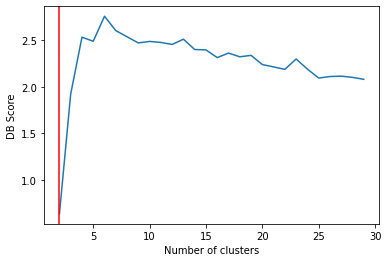

{0, 1}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

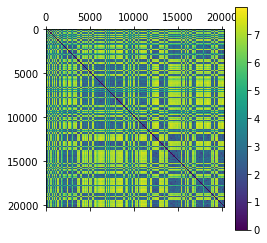

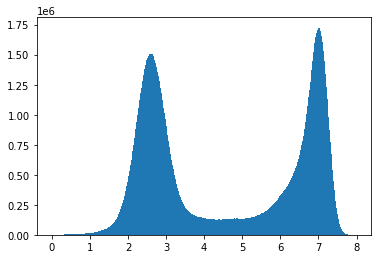

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

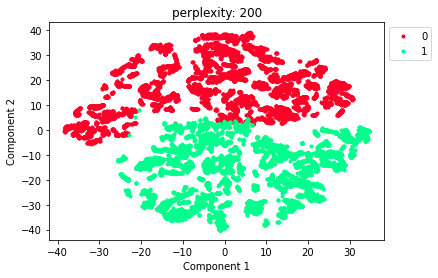

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9921155078105751


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.15467453000869505
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.7417127071823204
layer 4: 0.6799033149171271
layer 5: 0.587189226519337
layer 6: 0.4172133977900553
layer 7: 0.2472375690607735
layer 8: 0.11975569751381217
Epoch: 00 | Batch: 000 / 011 | Total loss: 0.701 | Reg loss: 0.017 | Tree loss: 0.701 | Accuracy: 0.584000 | 1.536 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 0.701 | Reg loss: 0.017 | Tree loss: 0.701 | Accuracy: 0.510500 | 1.461 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 0.699 | Reg loss: 0.017 | Tree loss: 0.699 | Accuracy: 0.520500 | 1.434 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 0.697 | Reg loss: 0.016 | Tree loss: 0.697 | Accuracy: 0.521500 | 1.341 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 0.692 | Reg loss: 0.016 | Tree loss: 0.692 | Accuracy: 0.552500 | 1.338 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 0.692 | Reg loss: 0.015 | Tree loss: 0.692 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 0.695 | Reg loss: 0.012 | Tree loss: 0.695 | Accuracy: 0.665000 | 1.32 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 0.695 | Reg loss: 0.012 | Tree loss: 0.695 | Accuracy: 0.679500 | 1.32 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 0.693 | Reg loss: 0.012 | Tree loss: 0.693 | Accuracy: 0.682500 | 1.32 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 0.691 | Reg loss: 0.012 | Tree loss: 0.691 | Accuracy: 0.700500 | 1.315 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 0.690 | Reg loss: 0.012 | Tree loss: 0.690 | Accuracy: 0.653500 | 1.315 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 0.686 | Reg loss: 0.012 | Tree loss: 0.686 | Accu

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 0.694 | Reg loss: 0.011 | Tree loss: 0.694 | Accuracy: 0.686000 | 1.316 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 0.692 | Reg loss: 0.011 | Tree loss: 0.692 | Accuracy: 0.703500 | 1.315 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 0.690 | Reg loss: 0.011 | Tree loss: 0.690 | Accuracy: 0.697000 | 1.315 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 0.686 | Reg loss: 0.011 | Tree loss: 0.686 | Accuracy: 0.687500 | 1.313 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 0.685 | Reg loss: 0.012 | Tree loss: 0.685 | Accuracy: 0.646000 | 1.313 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 0.681 | Reg loss: 0.012 | Tree loss: 0.681 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 0.683 | Reg loss: 0.011 | Tree loss: 0.683 | Accuracy: 0.716500 | 1.313 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 0.680 | Reg loss: 0.011 | Tree loss: 0.680 | Accuracy: 0.707000 | 1.313 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 0.675 | Reg loss: 0.011 | Tree loss: 0.675 | Accuracy: 0.703500 | 1.313 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 0.671 | Reg loss: 0.011 | Tree loss: 0.671 | Accuracy: 0.661000 | 1.311 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 0.667 | Reg loss: 0.011 | Tree loss: 0.667 | Accuracy: 0.638000 | 1.311 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 0.656 | Reg loss: 0.012 | Tree loss: 0.656 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 0.663 | Reg loss: 0.012 | Tree loss: 0.663 | Accuracy: 0.692000 | 1.312 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 0.658 | Reg loss: 0.012 | Tree loss: 0.658 | Accuracy: 0.653500 | 1.312 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 0.650 | Reg loss: 0.012 | Tree loss: 0.650 | Accuracy: 0.636000 | 1.312 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 0.645 | Reg loss: 0.012 | Tree loss: 0.645 | Accuracy: 0.618500 | 1.31 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 0.649 | Reg loss: 0.012 | Tree loss: 0.649 | Accuracy: 0.611500 | 1.31 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 0.652 | Reg loss: 0.012 | Tree loss: 0.652 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 0.640 | Reg loss: 0.013 | Tree loss: 0.640 | Accuracy: 0.725000 | 1.311 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 0.629 | Reg loss: 0.013 | Tree loss: 0.629 | Accuracy: 0.696000 | 1.311 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 0.628 | Reg loss: 0.013 | Tree loss: 0.628 | Accuracy: 0.648500 | 1.311 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 0.619 | Reg loss: 0.013 | Tree loss: 0.619 | Accuracy: 0.660500 | 1.31 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 0.617 | Reg loss: 0.013 | Tree loss: 0.617 | Accuracy: 0.647000 | 1.31 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 0.612 | Reg loss: 0.013 | Tree loss: 0.612 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 0.617 | Reg loss: 0.015 | Tree loss: 0.617 | Accuracy: 0.723000 | 1.311 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 0.618 | Reg loss: 0.015 | Tree loss: 0.618 | Accuracy: 0.719000 | 1.311 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 0.616 | Reg loss: 0.015 | Tree loss: 0.616 | Accuracy: 0.671500 | 1.311 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 0.610 | Reg loss: 0.015 | Tree loss: 0.610 | Accuracy: 0.656000 | 1.31 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 0.603 | Reg loss: 0.015 | Tree loss: 0.603 | Accuracy: 0.656500 | 1.31 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 0.580 | Reg loss: 0.015 | Tree loss: 0.580 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 0.629 | Reg loss: 0.016 | Tree loss: 0.629 | Accuracy: 0.704000 | 1.31 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 0.618 | Reg loss: 0.016 | Tree loss: 0.618 | Accuracy: 0.723000 | 1.31 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 0.604 | Reg loss: 0.016 | Tree loss: 0.604 | Accuracy: 0.716500 | 1.31 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 0.597 | Reg loss: 0.016 | Tree loss: 0.597 | Accuracy: 0.674500 | 1.31 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 0.585 | Reg loss: 0.016 | Tree loss: 0.585 | Accuracy: 0.676000 | 1.31 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 0.576 | Reg loss: 0.016 | Tree loss: 0.576 | Accura

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 0.637 | Reg loss: 0.016 | Tree loss: 0.637 | Accuracy: 0.702500 | 1.31 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 0.600 | Reg loss: 0.016 | Tree loss: 0.600 | Accuracy: 0.725500 | 1.31 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 0.586 | Reg loss: 0.016 | Tree loss: 0.586 | Accuracy: 0.728500 | 1.31 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 0.560 | Reg loss: 0.016 | Tree loss: 0.560 | Accuracy: 0.739000 | 1.309 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 0.575 | Reg loss: 0.016 | Tree loss: 0.575 | Accuracy: 0.704500 | 1.309 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 0.576 | Reg loss: 0.016 | Tree loss: 0.576 | Accu

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 0.616 | Reg loss: 0.017 | Tree loss: 0.616 | Accuracy: 0.704500 | 1.31 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 0.597 | Reg loss: 0.017 | Tree loss: 0.597 | Accuracy: 0.717500 | 1.31 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 0.572 | Reg loss: 0.017 | Tree loss: 0.572 | Accuracy: 0.735500 | 1.31 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 0.569 | Reg loss: 0.017 | Tree loss: 0.569 | Accuracy: 0.728500 | 1.309 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 0.551 | Reg loss: 0.017 | Tree loss: 0.551 | Accuracy: 0.725000 | 1.309 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 0.544 | Reg loss: 0.017 | Tree loss: 0.544 | Accu

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 0.620 | Reg loss: 0.018 | Tree loss: 0.620 | Accuracy: 0.700000 | 1.309 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 0.572 | Reg loss: 0.018 | Tree loss: 0.572 | Accuracy: 0.735500 | 1.309 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 0.573 | Reg loss: 0.018 | Tree loss: 0.573 | Accuracy: 0.729000 | 1.309 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 0.554 | Reg loss: 0.018 | Tree loss: 0.554 | Accuracy: 0.718500 | 1.309 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 0.556 | Reg loss: 0.018 | Tree loss: 0.556 | Accuracy: 0.714500 | 1.309 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 0.532 | Reg loss: 0.018 | Tree loss: 0.532 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 0.590 | Reg loss: 0.018 | Tree loss: 0.590 | Accuracy: 0.708000 | 1.309 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 0.576 | Reg loss: 0.018 | Tree loss: 0.576 | Accuracy: 0.705500 | 1.309 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 0.552 | Reg loss: 0.018 | Tree loss: 0.552 | Accuracy: 0.744000 | 1.309 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 0.538 | Reg loss: 0.018 | Tree loss: 0.538 | Accuracy: 0.734500 | 1.309 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 0.533 | Reg loss: 0.018 | Tree loss: 0.533 | Accuracy: 0.741000 | 1.309 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 0.528 | Reg loss: 0.018 | Tree loss: 0.528 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 0.587 | Reg loss: 0.019 | Tree loss: 0.587 | Accuracy: 0.688000 | 1.309 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 0.556 | Reg loss: 0.019 | Tree loss: 0.556 | Accuracy: 0.711000 | 1.309 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 0.533 | Reg loss: 0.019 | Tree loss: 0.533 | Accuracy: 0.733000 | 1.309 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 0.513 | Reg loss: 0.019 | Tree loss: 0.513 | Accuracy: 0.769500 | 1.309 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 0.515 | Reg loss: 0.019 | Tree loss: 0.515 | Accuracy: 0.784500 | 1.309 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 0.519 | Reg loss: 0.019 | Tree loss: 0.519 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 0.578 | Reg loss: 0.019 | Tree loss: 0.578 | Accuracy: 0.696500 | 1.309 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 0.535 | Reg loss: 0.019 | Tree loss: 0.535 | Accuracy: 0.719000 | 1.309 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 0.517 | Reg loss: 0.019 | Tree loss: 0.517 | Accuracy: 0.732500 | 1.309 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 0.497 | Reg loss: 0.019 | Tree loss: 0.497 | Accuracy: 0.796000 | 1.308 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.506 | Reg loss: 0.019 | Tree loss: 0.506 | Accuracy: 0.786500 | 1.308 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 0.496 | Reg loss: 0.019 | Tree loss: 0.496 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 0.548 | Reg loss: 0.019 | Tree loss: 0.548 | Accuracy: 0.709500 | 1.309 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 0.528 | Reg loss: 0.019 | Tree loss: 0.528 | Accuracy: 0.729500 | 1.309 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 0.507 | Reg loss: 0.019 | Tree loss: 0.507 | Accuracy: 0.752500 | 1.309 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 0.482 | Reg loss: 0.019 | Tree loss: 0.482 | Accuracy: 0.820500 | 1.308 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 0.481 | Reg loss: 0.019 | Tree loss: 0.481 | Accuracy: 0.804000 | 1.308 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 0.492 | Reg loss: 0.019 | Tree loss: 0.492 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 0.552 | Reg loss: 0.019 | Tree loss: 0.552 | Accuracy: 0.726500 | 1.308 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 0.536 | Reg loss: 0.019 | Tree loss: 0.536 | Accuracy: 0.746500 | 1.308 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 0.509 | Reg loss: 0.019 | Tree loss: 0.509 | Accuracy: 0.774500 | 1.308 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 0.478 | Reg loss: 0.019 | Tree loss: 0.478 | Accuracy: 0.803500 | 1.308 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 0.476 | Reg loss: 0.019 | Tree loss: 0.476 | Accuracy: 0.812000 | 1.308 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 0.503 | Reg loss: 0.019 | Tree loss: 0.503 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 0.562 | Reg loss: 0.020 | Tree loss: 0.562 | Accuracy: 0.739000 | 1.308 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 0.537 | Reg loss: 0.020 | Tree loss: 0.537 | Accuracy: 0.768000 | 1.308 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 0.502 | Reg loss: 0.020 | Tree loss: 0.502 | Accuracy: 0.781000 | 1.308 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 0.473 | Reg loss: 0.020 | Tree loss: 0.473 | Accuracy: 0.805500 | 1.308 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 0.466 | Reg loss: 0.020 | Tree loss: 0.466 | Accuracy: 0.827000 | 1.308 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 0.460 | Reg loss: 0.020 | Tree loss: 0.460 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 0.529 | Reg loss: 0.020 | Tree loss: 0.529 | Accuracy: 0.781000 | 1.308 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 0.532 | Reg loss: 0.020 | Tree loss: 0.532 | Accuracy: 0.773500 | 1.308 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 0.531 | Reg loss: 0.020 | Tree loss: 0.531 | Accuracy: 0.748000 | 1.308 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 0.469 | Reg loss: 0.020 | Tree loss: 0.469 | Accuracy: 0.811000 | 1.308 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 0.459 | Reg loss: 0.020 | Tree loss: 0.459 | Accuracy: 0.811500 | 1.308 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 0.470 | Reg loss: 0.020 | Tree loss: 0.470 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 0.543 | Reg loss: 0.020 | Tree loss: 0.543 | Accuracy: 0.768500 | 1.308 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 0.543 | Reg loss: 0.020 | Tree loss: 0.543 | Accuracy: 0.765500 | 1.308 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 0.518 | Reg loss: 0.020 | Tree loss: 0.518 | Accuracy: 0.768500 | 1.308 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 0.480 | Reg loss: 0.020 | Tree loss: 0.480 | Accuracy: 0.787000 | 1.308 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 0.453 | Reg loss: 0.020 | Tree loss: 0.453 | Accuracy: 0.819000 | 1.307 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 0.461 | Reg loss: 0.020 | Tree loss: 0.461 | A

Epoch: 95 | Batch: 000 / 011 | Total loss: 0.534 | Reg loss: 0.020 | Tree loss: 0.534 | Accuracy: 0.767500 | 1.289 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 0.543 | Reg loss: 0.020 | Tree loss: 0.543 | Accuracy: 0.770500 | 1.289 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 0.513 | Reg loss: 0.020 | Tree loss: 0.513 | Accuracy: 0.784500 | 1.289 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 0.492 | Reg loss: 0.020 | Tree loss: 0.492 | Accuracy: 0.783500 | 1.288 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 0.463 | Reg loss: 0.020 | Tree loss: 0.463 | Accuracy: 0.813000 | 1.288 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.020 | Tree loss: 0.455 | Accuracy: 0.827000 | 1.288 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 0.449 | Reg loss: 0.020 | Tree loss: 0.449 | Accuracy: 0.818500 | 1.287 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 0.463 | Reg loss: 0.020 | Tree loss: 0.463 | Accuracy: 0.792000 | 1.287 sec/iter
Epoch: 9

Epoch: 100 | Batch: 000 / 011 | Total loss: 0.529 | Reg loss: 0.020 | Tree loss: 0.529 | Accuracy: 0.763500 | 1.272 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 0.532 | Reg loss: 0.020 | Tree loss: 0.532 | Accuracy: 0.773500 | 1.271 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 0.524 | Reg loss: 0.020 | Tree loss: 0.524 | Accuracy: 0.750500 | 1.271 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 0.476 | Reg loss: 0.021 | Tree loss: 0.476 | Accuracy: 0.793500 | 1.271 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 0.442 | Reg loss: 0.021 | Tree loss: 0.442 | Accuracy: 0.820500 | 1.27 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 0.451 | Reg loss: 0.021 | Tree loss: 0.451 | Accuracy: 0.815000 | 1.27 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 0.473 | Reg loss: 0.021 | Tree loss: 0.473 | Accuracy: 0.790500 | 1.27 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 0.469 | Reg loss: 0.021 | Tree loss: 0.469 | Accuracy: 0.790000 | 1.27 sec/iter
Epoc

Epoch: 105 | Batch: 000 / 011 | Total loss: 0.540 | Reg loss: 0.021 | Tree loss: 0.540 | Accuracy: 0.747000 | 1.256 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 0.513 | Reg loss: 0.021 | Tree loss: 0.513 | Accuracy: 0.775000 | 1.255 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 0.514 | Reg loss: 0.021 | Tree loss: 0.514 | Accuracy: 0.768000 | 1.255 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 0.473 | Reg loss: 0.021 | Tree loss: 0.473 | Accuracy: 0.790500 | 1.255 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 0.456 | Reg loss: 0.021 | Tree loss: 0.456 | Accuracy: 0.813500 | 1.254 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.822500 | 1.254 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.465 | Reg loss: 0.021 | Tree loss: 0.465 | Accuracy: 0.809500 | 1.254 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.482 | Reg loss: 0.021 | Tree loss: 0.482 | Accuracy: 0.772000 | 1.254 sec/iter


Epoch: 110 | Batch: 000 / 011 | Total loss: 0.514 | Reg loss: 0.021 | Tree loss: 0.514 | Accuracy: 0.764000 | 1.241 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 0.520 | Reg loss: 0.021 | Tree loss: 0.520 | Accuracy: 0.777000 | 1.241 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.518 | Reg loss: 0.021 | Tree loss: 0.518 | Accuracy: 0.746500 | 1.24 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.471 | Reg loss: 0.021 | Tree loss: 0.471 | Accuracy: 0.784000 | 1.24 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.811000 | 1.24 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.021 | Tree loss: 0.437 | Accuracy: 0.833000 | 1.239 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.466 | Reg loss: 0.021 | Tree loss: 0.466 | Accuracy: 0.786000 | 1.239 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.464 | Reg loss: 0.021 | Tree loss: 0.464 | Accuracy: 0.787500 | 1.239 sec/iter
Epo

Epoch: 115 | Batch: 000 / 011 | Total loss: 0.524 | Reg loss: 0.021 | Tree loss: 0.524 | Accuracy: 0.756000 | 1.227 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.518 | Reg loss: 0.021 | Tree loss: 0.518 | Accuracy: 0.765500 | 1.227 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.506 | Reg loss: 0.021 | Tree loss: 0.506 | Accuracy: 0.758000 | 1.227 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.466 | Reg loss: 0.021 | Tree loss: 0.466 | Accuracy: 0.791000 | 1.227 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.445 | Reg loss: 0.021 | Tree loss: 0.445 | Accuracy: 0.809000 | 1.226 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.433 | Reg loss: 0.021 | Tree loss: 0.433 | Accuracy: 0.833500 | 1.226 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.452 | Reg loss: 0.021 | Tree loss: 0.452 | Accuracy: 0.811500 | 1.226 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.804000 | 1.226 sec/iter


Epoch: 120 | Batch: 000 / 011 | Total loss: 0.517 | Reg loss: 0.021 | Tree loss: 0.517 | Accuracy: 0.762500 | 1.215 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.513 | Reg loss: 0.021 | Tree loss: 0.513 | Accuracy: 0.754000 | 1.215 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.491 | Reg loss: 0.021 | Tree loss: 0.491 | Accuracy: 0.761000 | 1.215 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.466 | Reg loss: 0.021 | Tree loss: 0.466 | Accuracy: 0.792500 | 1.214 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.021 | Tree loss: 0.438 | Accuracy: 0.814000 | 1.214 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 0.441 | Reg loss: 0.021 | Tree loss: 0.441 | Accuracy: 0.820000 | 1.214 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 0.450 | Reg loss: 0.021 | Tree loss: 0.450 | Accuracy: 0.798500 | 1.214 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 0.452 | Reg loss: 0.021 | Tree loss: 0.452 | Accuracy: 0.794500 | 1.213 sec/iter


Epoch: 125 | Batch: 000 / 011 | Total loss: 0.496 | Reg loss: 0.021 | Tree loss: 0.496 | Accuracy: 0.772500 | 1.204 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 0.511 | Reg loss: 0.021 | Tree loss: 0.511 | Accuracy: 0.758000 | 1.204 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 0.489 | Reg loss: 0.021 | Tree loss: 0.489 | Accuracy: 0.764500 | 1.203 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 0.455 | Reg loss: 0.021 | Tree loss: 0.455 | Accuracy: 0.799500 | 1.203 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 0.460 | Reg loss: 0.021 | Tree loss: 0.460 | Accuracy: 0.794500 | 1.203 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 0.449 | Reg loss: 0.021 | Tree loss: 0.449 | Accuracy: 0.817500 | 1.203 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy: 0.813000 | 1.203 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 0.449 | Reg loss: 0.021 | Tree loss: 0.449 | Accuracy: 0.806500 | 1.202 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 0.503 | Reg loss: 0.021 | Tree loss: 0.503 | Accuracy: 0.771500 | 1.193 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 0.503 | Reg loss: 0.021 | Tree loss: 0.503 | Accuracy: 0.771000 | 1.193 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 0.482 | Reg loss: 0.021 | Tree loss: 0.482 | Accuracy: 0.782000 | 1.193 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 0.468 | Reg loss: 0.021 | Tree loss: 0.468 | Accuracy: 0.778500 | 1.193 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.021 | Tree loss: 0.446 | Accuracy: 0.799500 | 1.193 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.021 | Tree loss: 0.437 | Accuracy: 0.828000 | 1.192 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.021 | Tree loss: 0.437 | Accuracy: 0.815000 | 1.192 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 0.457 | Reg loss: 0.021 | Tree loss: 0.457 | Accuracy: 0.797000 | 1.192 sec/iter


Epoch: 135 | Batch: 000 / 011 | Total loss: 0.514 | Reg loss: 0.021 | Tree loss: 0.514 | Accuracy: 0.753500 | 1.184 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 0.497 | Reg loss: 0.021 | Tree loss: 0.497 | Accuracy: 0.772000 | 1.184 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 0.493 | Reg loss: 0.021 | Tree loss: 0.493 | Accuracy: 0.755500 | 1.183 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 0.463 | Reg loss: 0.021 | Tree loss: 0.463 | Accuracy: 0.779000 | 1.183 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 0.453 | Reg loss: 0.021 | Tree loss: 0.453 | Accuracy: 0.785000 | 1.183 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 0.422 | Reg loss: 0.021 | Tree loss: 0.422 | Accuracy: 0.836000 | 1.183 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 0.454 | Reg loss: 0.021 | Tree loss: 0.454 | Accuracy: 0.797000 | 1.183 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 0.461 | Reg loss: 0.021 | Tree loss: 0.461 | Accuracy: 0.799000 | 1.183 sec/iter


Epoch: 140 | Batch: 000 / 011 | Total loss: 0.498 | Reg loss: 0.022 | Tree loss: 0.498 | Accuracy: 0.772500 | 1.175 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 0.504 | Reg loss: 0.022 | Tree loss: 0.504 | Accuracy: 0.757000 | 1.175 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 0.492 | Reg loss: 0.022 | Tree loss: 0.492 | Accuracy: 0.764500 | 1.174 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 0.462 | Reg loss: 0.022 | Tree loss: 0.462 | Accuracy: 0.787500 | 1.174 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 0.432 | Reg loss: 0.022 | Tree loss: 0.432 | Accuracy: 0.812500 | 1.174 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 0.444 | Reg loss: 0.022 | Tree loss: 0.444 | Accuracy: 0.814500 | 1.174 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 0.440 | Reg loss: 0.022 | Tree loss: 0.440 | Accuracy: 0.812000 | 1.174 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.022 | Tree loss: 0.435 | Accuracy: 0.817000 | 1.174 sec/iter


Epoch: 145 | Batch: 000 / 011 | Total loss: 0.500 | Reg loss: 0.022 | Tree loss: 0.500 | Accuracy: 0.765500 | 1.166 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 0.492 | Reg loss: 0.022 | Tree loss: 0.492 | Accuracy: 0.775500 | 1.166 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 0.479 | Reg loss: 0.022 | Tree loss: 0.479 | Accuracy: 0.787500 | 1.166 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 0.449 | Reg loss: 0.022 | Tree loss: 0.449 | Accuracy: 0.797500 | 1.166 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 0.436 | Reg loss: 0.022 | Tree loss: 0.436 | Accuracy: 0.816000 | 1.166 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 0.439 | Reg loss: 0.022 | Tree loss: 0.439 | Accuracy: 0.822500 | 1.166 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 0.435 | Reg loss: 0.022 | Tree loss: 0.435 | Accuracy: 0.810000 | 1.165 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 0.448 | Reg loss: 0.022 | Tree loss: 0.448 | Accuracy: 0.800500 | 1.165 sec/iter


Epoch: 150 | Batch: 000 / 011 | Total loss: 0.498 | Reg loss: 0.022 | Tree loss: 0.498 | Accuracy: 0.767500 | 1.159 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.490 | Reg loss: 0.022 | Tree loss: 0.490 | Accuracy: 0.769000 | 1.158 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 0.491 | Reg loss: 0.022 | Tree loss: 0.491 | Accuracy: 0.767500 | 1.158 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 0.456 | Reg loss: 0.022 | Tree loss: 0.456 | Accuracy: 0.790000 | 1.158 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 0.448 | Reg loss: 0.022 | Tree loss: 0.448 | Accuracy: 0.802500 | 1.158 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 0.442 | Reg loss: 0.022 | Tree loss: 0.442 | Accuracy: 0.812500 | 1.158 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 0.435 | Reg loss: 0.022 | Tree loss: 0.435 | Accuracy: 0.808000 | 1.158 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.022 | Tree loss: 0.424 | Accuracy: 0.826500 | 1.157 sec/iter


Epoch: 155 | Batch: 000 / 011 | Total loss: 0.500 | Reg loss: 0.022 | Tree loss: 0.500 | Accuracy: 0.764500 | 1.151 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.022 | Tree loss: 0.491 | Accuracy: 0.766500 | 1.151 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.496 | Reg loss: 0.022 | Tree loss: 0.496 | Accuracy: 0.753500 | 1.151 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.459 | Reg loss: 0.022 | Tree loss: 0.459 | Accuracy: 0.780000 | 1.151 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.022 | Tree loss: 0.438 | Accuracy: 0.814500 | 1.151 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 0.429 | Reg loss: 0.022 | Tree loss: 0.429 | Accuracy: 0.830000 | 1.15 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 0.438 | Reg loss: 0.022 | Tree loss: 0.438 | Accuracy: 0.799000 | 1.15 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.022 | Tree loss: 0.435 | Accuracy: 0.813000 | 1.15 sec/iter
Epo

Epoch: 160 | Batch: 000 / 011 | Total loss: 0.487 | Reg loss: 0.022 | Tree loss: 0.487 | Accuracy: 0.778000 | 1.144 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.490 | Reg loss: 0.022 | Tree loss: 0.490 | Accuracy: 0.763000 | 1.144 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.484 | Reg loss: 0.022 | Tree loss: 0.484 | Accuracy: 0.763500 | 1.144 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.453 | Reg loss: 0.022 | Tree loss: 0.453 | Accuracy: 0.777500 | 1.144 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.437 | Reg loss: 0.022 | Tree loss: 0.437 | Accuracy: 0.809500 | 1.144 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.431 | Reg loss: 0.022 | Tree loss: 0.431 | Accuracy: 0.830000 | 1.144 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 0.439 | Reg loss: 0.022 | Tree loss: 0.439 | Accuracy: 0.807000 | 1.143 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 0.444 | Reg loss: 0.022 | Tree loss: 0.444 | Accuracy: 0.804000 | 1.143 sec/iter


Epoch: 165 | Batch: 000 / 011 | Total loss: 0.490 | Reg loss: 0.022 | Tree loss: 0.490 | Accuracy: 0.763000 | 1.138 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.521 | Reg loss: 0.022 | Tree loss: 0.521 | Accuracy: 0.742500 | 1.138 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.484 | Reg loss: 0.022 | Tree loss: 0.484 | Accuracy: 0.763000 | 1.137 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.468 | Reg loss: 0.022 | Tree loss: 0.468 | Accuracy: 0.781000 | 1.137 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.432 | Reg loss: 0.022 | Tree loss: 0.432 | Accuracy: 0.811500 | 1.137 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.427 | Reg loss: 0.022 | Tree loss: 0.427 | Accuracy: 0.822500 | 1.137 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.426 | Reg loss: 0.022 | Tree loss: 0.426 | Accuracy: 0.813500 | 1.137 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.441 | Reg loss: 0.022 | Tree loss: 0.441 | Accuracy: 0.802000 | 1.137 sec/iter


Epoch: 170 | Batch: 000 / 011 | Total loss: 0.479 | Reg loss: 0.022 | Tree loss: 0.479 | Accuracy: 0.774500 | 1.132 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 0.501 | Reg loss: 0.022 | Tree loss: 0.501 | Accuracy: 0.753000 | 1.131 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 0.476 | Reg loss: 0.022 | Tree loss: 0.476 | Accuracy: 0.770500 | 1.131 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.456 | Reg loss: 0.022 | Tree loss: 0.456 | Accuracy: 0.786500 | 1.131 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.022 | Tree loss: 0.429 | Accuracy: 0.820000 | 1.131 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.422 | Reg loss: 0.022 | Tree loss: 0.422 | Accuracy: 0.817000 | 1.131 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.443 | Reg loss: 0.022 | Tree loss: 0.443 | Accuracy: 0.797500 | 1.131 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.454 | Reg loss: 0.022 | Tree loss: 0.454 | Accuracy: 0.790500 | 1.131 sec/iter


Epoch: 175 | Batch: 000 / 011 | Total loss: 0.483 | Reg loss: 0.023 | Tree loss: 0.483 | Accuracy: 0.766000 | 1.126 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.023 | Tree loss: 0.476 | Accuracy: 0.777000 | 1.126 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 0.464 | Reg loss: 0.023 | Tree loss: 0.464 | Accuracy: 0.788500 | 1.126 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 0.454 | Reg loss: 0.023 | Tree loss: 0.454 | Accuracy: 0.801000 | 1.125 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 0.421 | Reg loss: 0.023 | Tree loss: 0.421 | Accuracy: 0.827500 | 1.125 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 0.433 | Reg loss: 0.023 | Tree loss: 0.433 | Accuracy: 0.830000 | 1.125 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.023 | Tree loss: 0.431 | Accuracy: 0.798500 | 1.125 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.023 | Tree loss: 0.435 | Accuracy: 0.805500 | 1.125 sec/iter


Epoch: 180 | Batch: 000 / 011 | Total loss: 0.493 | Reg loss: 0.023 | Tree loss: 0.493 | Accuracy: 0.773500 | 1.12 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 0.477 | Reg loss: 0.023 | Tree loss: 0.477 | Accuracy: 0.769500 | 1.12 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 0.475 | Reg loss: 0.023 | Tree loss: 0.475 | Accuracy: 0.767000 | 1.12 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 0.449 | Reg loss: 0.023 | Tree loss: 0.449 | Accuracy: 0.786000 | 1.12 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 0.419 | Reg loss: 0.023 | Tree loss: 0.419 | Accuracy: 0.819000 | 1.12 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 0.434 | Reg loss: 0.023 | Tree loss: 0.434 | Accuracy: 0.818000 | 1.12 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.023 | Tree loss: 0.432 | Accuracy: 0.810000 | 1.12 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 0.448 | Reg loss: 0.023 | Tree loss: 0.448 | Accuracy: 0.790000 | 1.12 sec/iter
Epoch: 1

Epoch: 185 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.023 | Tree loss: 0.473 | Accuracy: 0.777500 | 1.115 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 0.507 | Reg loss: 0.023 | Tree loss: 0.507 | Accuracy: 0.755500 | 1.115 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 0.460 | Reg loss: 0.023 | Tree loss: 0.460 | Accuracy: 0.786500 | 1.115 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 0.455 | Reg loss: 0.023 | Tree loss: 0.455 | Accuracy: 0.786000 | 1.115 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 0.433 | Reg loss: 0.023 | Tree loss: 0.433 | Accuracy: 0.811500 | 1.115 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 0.409 | Reg loss: 0.023 | Tree loss: 0.409 | Accuracy: 0.843500 | 1.115 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 0.425 | Reg loss: 0.023 | Tree loss: 0.425 | Accuracy: 0.812000 | 1.115 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.023 | Tree loss: 0.445 | Accuracy: 0.791000 | 1.115 sec/iter


Epoch: 190 | Batch: 000 / 011 | Total loss: 0.469 | Reg loss: 0.023 | Tree loss: 0.469 | Accuracy: 0.781500 | 1.11 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.023 | Tree loss: 0.475 | Accuracy: 0.777500 | 1.11 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 0.480 | Reg loss: 0.023 | Tree loss: 0.480 | Accuracy: 0.771000 | 1.11 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 0.459 | Reg loss: 0.023 | Tree loss: 0.459 | Accuracy: 0.790500 | 1.11 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.023 | Tree loss: 0.424 | Accuracy: 0.815500 | 1.11 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 0.423 | Reg loss: 0.023 | Tree loss: 0.423 | Accuracy: 0.830000 | 1.11 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.023 | Tree loss: 0.432 | Accuracy: 0.799000 | 1.11 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 0.443 | Reg loss: 0.023 | Tree loss: 0.443 | Accuracy: 0.792000 | 1.11 sec/iter
Epoch: 1

Epoch: 195 | Batch: 000 / 011 | Total loss: 0.495 | Reg loss: 0.023 | Tree loss: 0.495 | Accuracy: 0.761000 | 1.106 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 0.461 | Reg loss: 0.023 | Tree loss: 0.461 | Accuracy: 0.783500 | 1.106 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.023 | Tree loss: 0.459 | Accuracy: 0.791000 | 1.106 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 0.430 | Reg loss: 0.023 | Tree loss: 0.430 | Accuracy: 0.805500 | 1.105 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 0.432 | Reg loss: 0.023 | Tree loss: 0.432 | Accuracy: 0.802000 | 1.105 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.023 | Tree loss: 0.413 | Accuracy: 0.839000 | 1.105 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.023 | Tree loss: 0.416 | Accuracy: 0.818500 | 1.105 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.023 | Tree loss: 0.422 | Accuracy: 0.806000 | 1.105 sec/iter


Epoch: 200 | Batch: 000 / 011 | Total loss: 0.469 | Reg loss: 0.023 | Tree loss: 0.469 | Accuracy: 0.783000 | 1.101 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 0.484 | Reg loss: 0.023 | Tree loss: 0.484 | Accuracy: 0.774500 | 1.101 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 0.470 | Reg loss: 0.023 | Tree loss: 0.470 | Accuracy: 0.789000 | 1.101 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.023 | Tree loss: 0.434 | Accuracy: 0.805500 | 1.101 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.023 | Tree loss: 0.429 | Accuracy: 0.818500 | 1.101 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 0.411 | Reg loss: 0.023 | Tree loss: 0.411 | Accuracy: 0.834000 | 1.101 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.023 | Tree loss: 0.432 | Accuracy: 0.796000 | 1.101 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.023 | Tree loss: 0.427 | Accuracy: 0.812500 | 1.101 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 0.471 | Reg loss: 0.023 | Tree loss: 0.471 | Accuracy: 0.775500 | 1.097 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 0.481 | Reg loss: 0.023 | Tree loss: 0.481 | Accuracy: 0.763000 | 1.097 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 0.453 | Reg loss: 0.023 | Tree loss: 0.453 | Accuracy: 0.789000 | 1.097 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 0.423 | Reg loss: 0.023 | Tree loss: 0.423 | Accuracy: 0.804500 | 1.097 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.023 | Tree loss: 0.416 | Accuracy: 0.821500 | 1.097 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 0.425 | Reg loss: 0.023 | Tree loss: 0.425 | Accuracy: 0.822500 | 1.097 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 0.433 | Reg loss: 0.023 | Tree loss: 0.433 | Accuracy: 0.795000 | 1.097 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.023 | Tree loss: 0.413 | Accuracy: 0.813500 | 1.097 sec/iter


Epoch: 210 | Batch: 000 / 011 | Total loss: 0.478 | Reg loss: 0.023 | Tree loss: 0.478 | Accuracy: 0.760500 | 1.093 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 0.490 | Reg loss: 0.023 | Tree loss: 0.490 | Accuracy: 0.766500 | 1.093 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 0.437 | Reg loss: 0.023 | Tree loss: 0.437 | Accuracy: 0.809500 | 1.093 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 0.423 | Reg loss: 0.023 | Tree loss: 0.423 | Accuracy: 0.817000 | 1.093 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 0.428 | Reg loss: 0.023 | Tree loss: 0.428 | Accuracy: 0.818000 | 1.093 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 0.405 | Reg loss: 0.023 | Tree loss: 0.405 | Accuracy: 0.835000 | 1.093 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.023 | Tree loss: 0.419 | Accuracy: 0.811500 | 1.093 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.023 | Tree loss: 0.424 | Accuracy: 0.813500 | 1.093 sec/iter


Epoch: 215 | Batch: 000 / 011 | Total loss: 0.470 | Reg loss: 0.023 | Tree loss: 0.470 | Accuracy: 0.771000 | 1.089 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 0.488 | Reg loss: 0.023 | Tree loss: 0.488 | Accuracy: 0.759000 | 1.089 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 0.467 | Reg loss: 0.023 | Tree loss: 0.467 | Accuracy: 0.788000 | 1.089 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.023 | Tree loss: 0.422 | Accuracy: 0.804000 | 1.089 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 0.421 | Reg loss: 0.023 | Tree loss: 0.421 | Accuracy: 0.822000 | 1.089 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 0.430 | Reg loss: 0.023 | Tree loss: 0.430 | Accuracy: 0.823500 | 1.089 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 0.404 | Reg loss: 0.023 | Tree loss: 0.404 | Accuracy: 0.825500 | 1.089 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.023 | Tree loss: 0.422 | Accuracy: 0.812000 | 1.089 sec/iter


Epoch: 220 | Batch: 000 / 011 | Total loss: 0.461 | Reg loss: 0.023 | Tree loss: 0.461 | Accuracy: 0.789000 | 1.086 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 0.493 | Reg loss: 0.023 | Tree loss: 0.493 | Accuracy: 0.755500 | 1.086 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 0.451 | Reg loss: 0.023 | Tree loss: 0.451 | Accuracy: 0.787000 | 1.086 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.023 | Tree loss: 0.447 | Accuracy: 0.794500 | 1.086 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.023 | Tree loss: 0.424 | Accuracy: 0.808000 | 1.086 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 0.417 | Reg loss: 0.024 | Tree loss: 0.417 | Accuracy: 0.831500 | 1.085 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.024 | Tree loss: 0.410 | Accuracy: 0.820000 | 1.085 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.024 | Tree loss: 0.427 | Accuracy: 0.795000 | 1.085 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 0.473 | Reg loss: 0.024 | Tree loss: 0.473 | Accuracy: 0.777000 | 1.082 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 0.463 | Reg loss: 0.024 | Tree loss: 0.463 | Accuracy: 0.779000 | 1.082 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 0.450 | Reg loss: 0.024 | Tree loss: 0.450 | Accuracy: 0.796000 | 1.082 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 0.432 | Reg loss: 0.024 | Tree loss: 0.432 | Accuracy: 0.808500 | 1.082 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.024 | Tree loss: 0.416 | Accuracy: 0.822000 | 1.082 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0.826000 | 1.082 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.024 | Tree loss: 0.420 | Accuracy: 0.808000 | 1.082 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 0.398 | Reg loss: 0.024 | Tree loss: 0.398 | Accuracy: 0.821000 | 1.082 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 0.472 | Reg loss: 0.024 | Tree loss: 0.472 | Accuracy: 0.780000 | 1.079 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 0.465 | Reg loss: 0.024 | Tree loss: 0.465 | Accuracy: 0.777500 | 1.079 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 0.446 | Reg loss: 0.024 | Tree loss: 0.446 | Accuracy: 0.801500 | 1.079 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 0.430 | Reg loss: 0.024 | Tree loss: 0.430 | Accuracy: 0.808500 | 1.079 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 0.416 | Reg loss: 0.024 | Tree loss: 0.416 | Accuracy: 0.822000 | 1.079 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0.821500 | 1.079 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.024 | Tree loss: 0.421 | Accuracy: 0.806500 | 1.079 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 0.428 | Reg loss: 0.024 | Tree loss: 0.428 | Accuracy: 0.797500 | 1.079 sec/iter


Epoch: 235 | Batch: 000 / 011 | Total loss: 0.475 | Reg loss: 0.024 | Tree loss: 0.475 | Accuracy: 0.777000 | 1.076 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 0.467 | Reg loss: 0.024 | Tree loss: 0.467 | Accuracy: 0.775500 | 1.076 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 0.444 | Reg loss: 0.024 | Tree loss: 0.444 | Accuracy: 0.806000 | 1.076 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 0.429 | Reg loss: 0.024 | Tree loss: 0.429 | Accuracy: 0.818000 | 1.076 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 0.413 | Reg loss: 0.024 | Tree loss: 0.413 | Accuracy: 0.834500 | 1.075 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.024 | Tree loss: 0.400 | Accuracy: 0.850000 | 1.075 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 0.409 | Reg loss: 0.024 | Tree loss: 0.409 | Accuracy: 0.825500 | 1.075 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.024 | Tree loss: 0.418 | Accuracy: 0.801000 | 1.075 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.024 | Tree loss: 0.477 | Accuracy: 0.788000 | 1.073 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 0.456 | Reg loss: 0.024 | Tree loss: 0.456 | Accuracy: 0.790000 | 1.073 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 0.428 | Reg loss: 0.024 | Tree loss: 0.428 | Accuracy: 0.810000 | 1.073 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.024 | Tree loss: 0.413 | Accuracy: 0.820000 | 1.072 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 0.411 | Reg loss: 0.024 | Tree loss: 0.411 | Accuracy: 0.822500 | 1.072 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 0.432 | Reg loss: 0.024 | Tree loss: 0.432 | Accuracy: 0.829000 | 1.072 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 0.407 | Reg loss: 0.024 | Tree loss: 0.407 | Accuracy: 0.814000 | 1.072 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.024 | Tree loss: 0.397 | Accuracy: 0.829000 | 1.072 sec/iter


Epoch: 245 | Batch: 000 / 011 | Total loss: 0.469 | Reg loss: 0.024 | Tree loss: 0.469 | Accuracy: 0.784000 | 1.07 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 0.438 | Reg loss: 0.024 | Tree loss: 0.438 | Accuracy: 0.799500 | 1.07 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 0.460 | Reg loss: 0.024 | Tree loss: 0.460 | Accuracy: 0.779500 | 1.07 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 0.413 | Reg loss: 0.024 | Tree loss: 0.413 | Accuracy: 0.821500 | 1.07 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 0.409 | Reg loss: 0.024 | Tree loss: 0.409 | Accuracy: 0.826000 | 1.069 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 0.416 | Reg loss: 0.024 | Tree loss: 0.416 | Accuracy: 0.833000 | 1.069 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.024 | Tree loss: 0.437 | Accuracy: 0.786000 | 1.069 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 0.420 | Reg loss: 0.024 | Tree loss: 0.420 | Accuracy: 0.797500 | 1.069 sec/iter
Epoc

Epoch: 250 | Batch: 000 / 011 | Total loss: 0.458 | Reg loss: 0.024 | Tree loss: 0.458 | Accuracy: 0.793000 | 1.067 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 0.467 | Reg loss: 0.024 | Tree loss: 0.467 | Accuracy: 0.781500 | 1.067 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 0.452 | Reg loss: 0.024 | Tree loss: 0.452 | Accuracy: 0.794000 | 1.067 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.024 | Tree loss: 0.444 | Accuracy: 0.797000 | 1.067 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 0.394 | Reg loss: 0.024 | Tree loss: 0.394 | Accuracy: 0.838500 | 1.067 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 0.404 | Reg loss: 0.024 | Tree loss: 0.404 | Accuracy: 0.841500 | 1.067 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.024 | Tree loss: 0.408 | Accuracy: 0.813000 | 1.067 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0.801500 | 1.067 sec/iter


Epoch: 255 | Batch: 000 / 011 | Total loss: 0.453 | Reg loss: 0.024 | Tree loss: 0.453 | Accuracy: 0.794000 | 1.064 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 0.458 | Reg loss: 0.024 | Tree loss: 0.458 | Accuracy: 0.785500 | 1.064 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 0.448 | Reg loss: 0.024 | Tree loss: 0.448 | Accuracy: 0.793500 | 1.064 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 0.416 | Reg loss: 0.024 | Tree loss: 0.416 | Accuracy: 0.819500 | 1.064 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 0.411 | Reg loss: 0.024 | Tree loss: 0.411 | Accuracy: 0.833500 | 1.064 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.024 | Tree loss: 0.410 | Accuracy: 0.839000 | 1.064 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 0.401 | Reg loss: 0.024 | Tree loss: 0.401 | Accuracy: 0.820500 | 1.064 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.024 | Tree loss: 0.426 | Accuracy: 0.801000 | 1.064 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 0.471 | Reg loss: 0.024 | Tree loss: 0.471 | Accuracy: 0.788000 | 1.062 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 0.808500 | 1.062 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 0.449 | Reg loss: 0.024 | Tree loss: 0.449 | Accuracy: 0.792500 | 1.062 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 0.436 | Reg loss: 0.024 | Tree loss: 0.436 | Accuracy: 0.797500 | 1.062 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.024 | Tree loss: 0.395 | Accuracy: 0.846500 | 1.062 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 0.399 | Reg loss: 0.024 | Tree loss: 0.399 | Accuracy: 0.835500 | 1.061 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.024 | Tree loss: 0.405 | Accuracy: 0.812000 | 1.061 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0.789000 | 1.061 sec/iter


Epoch: 265 | Batch: 000 / 011 | Total loss: 0.446 | Reg loss: 0.024 | Tree loss: 0.446 | Accuracy: 0.798000 | 1.059 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 0.458 | Reg loss: 0.024 | Tree loss: 0.458 | Accuracy: 0.795500 | 1.059 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.024 | Tree loss: 0.459 | Accuracy: 0.789000 | 1.059 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 0.412 | Reg loss: 0.024 | Tree loss: 0.412 | Accuracy: 0.814000 | 1.059 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 0.407 | Reg loss: 0.024 | Tree loss: 0.407 | Accuracy: 0.827500 | 1.059 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 0.403 | Reg loss: 0.024 | Tree loss: 0.403 | Accuracy: 0.845000 | 1.059 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.024 | Tree loss: 0.420 | Accuracy: 0.815500 | 1.059 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.024 | Tree loss: 0.429 | Accuracy: 0.789500 | 1.059 sec/iter


Epoch: 270 | Batch: 000 / 011 | Total loss: 0.459 | Reg loss: 0.024 | Tree loss: 0.459 | Accuracy: 0.787000 | 1.057 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.024 | Tree loss: 0.439 | Accuracy: 0.807000 | 1.057 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 0.435 | Reg loss: 0.024 | Tree loss: 0.435 | Accuracy: 0.808500 | 1.057 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.024 | Tree loss: 0.434 | Accuracy: 0.803000 | 1.057 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.024 | Tree loss: 0.402 | Accuracy: 0.817500 | 1.057 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.024 | Tree loss: 0.391 | Accuracy: 0.841000 | 1.057 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 0.400 | Reg loss: 0.024 | Tree loss: 0.400 | Accuracy: 0.824000 | 1.057 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.024 | Tree loss: 0.433 | Accuracy: 0.797000 | 1.057 sec/iter


Epoch: 275 | Batch: 000 / 011 | Total loss: 0.456 | Reg loss: 0.024 | Tree loss: 0.456 | Accuracy: 0.786000 | 1.055 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 0.443 | Reg loss: 0.024 | Tree loss: 0.443 | Accuracy: 0.809000 | 1.055 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 0.433 | Reg loss: 0.024 | Tree loss: 0.433 | Accuracy: 0.812500 | 1.054 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 0.434 | Reg loss: 0.024 | Tree loss: 0.434 | Accuracy: 0.805500 | 1.054 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 0.408 | Reg loss: 0.024 | Tree loss: 0.408 | Accuracy: 0.826500 | 1.054 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 0.410 | Reg loss: 0.024 | Tree loss: 0.410 | Accuracy: 0.841500 | 1.054 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.024 | Tree loss: 0.402 | Accuracy: 0.799500 | 1.054 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.024 | Tree loss: 0.418 | Accuracy: 0.795500 | 1.054 sec/iter


Epoch: 280 | Batch: 000 / 011 | Total loss: 0.452 | Reg loss: 0.024 | Tree loss: 0.452 | Accuracy: 0.785500 | 1.052 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.796000 | 1.052 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.815000 | 1.052 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 0.411 | Reg loss: 0.025 | Tree loss: 0.411 | Accuracy: 0.823500 | 1.052 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 0.397 | Reg loss: 0.025 | Tree loss: 0.397 | Accuracy: 0.841000 | 1.052 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.025 | Tree loss: 0.406 | Accuracy: 0.856500 | 1.052 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.025 | Tree loss: 0.413 | Accuracy: 0.803500 | 1.052 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 0.409 | Reg loss: 0.025 | Tree loss: 0.409 | Accuracy: 0.810000 | 1.052 sec/iter


Epoch: 285 | Batch: 000 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.790500 | 1.05 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.777000 | 1.05 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.813000 | 1.05 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 0.388 | Reg loss: 0.025 | Tree loss: 0.388 | Accuracy: 0.828000 | 1.05 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 0.405 | Reg loss: 0.025 | Tree loss: 0.405 | Accuracy: 0.837000 | 1.05 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 0.405 | Reg loss: 0.025 | Tree loss: 0.405 | Accuracy: 0.836000 | 1.05 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.025 | Tree loss: 0.403 | Accuracy: 0.819500 | 1.05 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 0.399 | Reg loss: 0.025 | Tree loss: 0.399 | Accuracy: 0.817000 | 1.05 sec/iter
Epoch: 2

Epoch: 290 | Batch: 000 / 011 | Total loss: 0.445 | Reg loss: 0.025 | Tree loss: 0.445 | Accuracy: 0.799000 | 1.048 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 0.449 | Reg loss: 0.025 | Tree loss: 0.449 | Accuracy: 0.793000 | 1.048 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.802500 | 1.048 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.025 | Tree loss: 0.422 | Accuracy: 0.800500 | 1.048 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 0.401 | Reg loss: 0.025 | Tree loss: 0.401 | Accuracy: 0.836500 | 1.048 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 0.422 | Reg loss: 0.025 | Tree loss: 0.422 | Accuracy: 0.832000 | 1.048 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 0.395 | Reg loss: 0.025 | Tree loss: 0.395 | Accuracy: 0.837000 | 1.048 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.025 | Tree loss: 0.397 | Accuracy: 0.816500 | 1.048 sec/iter


Epoch: 295 | Batch: 000 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.788000 | 1.046 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 0.438 | Reg loss: 0.025 | Tree loss: 0.438 | Accuracy: 0.798500 | 1.046 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 0.422 | Reg loss: 0.025 | Tree loss: 0.422 | Accuracy: 0.804000 | 1.046 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 0.409 | Reg loss: 0.025 | Tree loss: 0.409 | Accuracy: 0.823500 | 1.046 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 0.391 | Reg loss: 0.025 | Tree loss: 0.391 | Accuracy: 0.862000 | 1.046 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 0.426 | Reg loss: 0.025 | Tree loss: 0.426 | Accuracy: 0.807500 | 1.046 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 0.403 | Reg loss: 0.025 | Tree loss: 0.403 | Accuracy: 0.805500 | 1.046 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.806500 | 1.046 sec/iter


Epoch: 300 | Batch: 000 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.798000 | 1.044 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 0.440 | Reg loss: 0.025 | Tree loss: 0.440 | Accuracy: 0.805000 | 1.044 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.805000 | 1.044 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy: 0.812500 | 1.044 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 0.407 | Reg loss: 0.025 | Tree loss: 0.407 | Accuracy: 0.835000 | 1.044 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 0.380 | Reg loss: 0.025 | Tree loss: 0.380 | Accuracy: 0.866500 | 1.044 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.025 | Tree loss: 0.411 | Accuracy: 0.802500 | 1.044 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.789000 | 1.044 sec/iter


Epoch: 305 | Batch: 000 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.789500 | 1.042 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 0.429 | Reg loss: 0.025 | Tree loss: 0.429 | Accuracy: 0.804500 | 1.042 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.797500 | 1.042 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 0.428 | Reg loss: 0.025 | Tree loss: 0.428 | Accuracy: 0.797000 | 1.042 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 0.405 | Reg loss: 0.025 | Tree loss: 0.405 | Accuracy: 0.837000 | 1.042 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.025 | Tree loss: 0.401 | Accuracy: 0.841000 | 1.042 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.025 | Tree loss: 0.410 | Accuracy: 0.808000 | 1.042 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.025 | Tree loss: 0.410 | Accuracy: 0.798000 | 1.042 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.804000 | 1.041 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 0.445 | Reg loss: 0.025 | Tree loss: 0.445 | Accuracy: 0.805000 | 1.041 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 0.423 | Reg loss: 0.025 | Tree loss: 0.423 | Accuracy: 0.820000 | 1.04 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.025 | Tree loss: 0.403 | Accuracy: 0.825000 | 1.04 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.025 | Tree loss: 0.388 | Accuracy: 0.865500 | 1.04 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 0.411 | Reg loss: 0.025 | Tree loss: 0.411 | Accuracy: 0.827500 | 1.04 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.025 | Tree loss: 0.405 | Accuracy: 0.810500 | 1.04 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.800000 | 1.04 sec/iter
Epoch:

Epoch: 315 | Batch: 000 / 011 | Total loss: 0.452 | Reg loss: 0.025 | Tree loss: 0.452 | Accuracy: 0.791500 | 1.039 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.451 | Reg loss: 0.025 | Tree loss: 0.451 | Accuracy: 0.799000 | 1.039 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.443 | Reg loss: 0.025 | Tree loss: 0.443 | Accuracy: 0.804000 | 1.039 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 0.401 | Reg loss: 0.025 | Tree loss: 0.401 | Accuracy: 0.827000 | 1.039 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 0.395 | Reg loss: 0.025 | Tree loss: 0.395 | Accuracy: 0.831500 | 1.039 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.025 | Tree loss: 0.395 | Accuracy: 0.849500 | 1.039 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 0.423 | Reg loss: 0.025 | Tree loss: 0.423 | Accuracy: 0.798500 | 1.039 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 0.380 | Reg loss: 0.025 | Tree loss: 0.380 | Accuracy: 0.829500 | 1.039 sec/iter


Epoch: 320 | Batch: 000 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.812500 | 1.037 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 0.451 | Reg loss: 0.025 | Tree loss: 0.451 | Accuracy: 0.792000 | 1.037 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 0.443 | Reg loss: 0.025 | Tree loss: 0.443 | Accuracy: 0.801000 | 1.037 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.415 | Reg loss: 0.025 | Tree loss: 0.415 | Accuracy: 0.811000 | 1.037 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.025 | Tree loss: 0.388 | Accuracy: 0.843500 | 1.037 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 0.385 | Reg loss: 0.025 | Tree loss: 0.385 | Accuracy: 0.870500 | 1.037 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.809500 | 1.037 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.025 | Tree loss: 0.401 | Accuracy: 0.814000 | 1.037 sec/iter


Epoch: 325 | Batch: 000 / 011 | Total loss: 0.448 | Reg loss: 0.025 | Tree loss: 0.448 | Accuracy: 0.800500 | 1.035 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 0.428 | Reg loss: 0.025 | Tree loss: 0.428 | Accuracy: 0.806500 | 1.035 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy: 0.826000 | 1.035 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.025 | Tree loss: 0.403 | Accuracy: 0.826500 | 1.035 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 0.408 | Reg loss: 0.025 | Tree loss: 0.408 | Accuracy: 0.840500 | 1.035 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.393 | Reg loss: 0.025 | Tree loss: 0.393 | Accuracy: 0.838000 | 1.035 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 0.400 | Reg loss: 0.025 | Tree loss: 0.400 | Accuracy: 0.802000 | 1.035 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.416 | Reg loss: 0.025 | Tree loss: 0.416 | Accuracy: 0.790000 | 1.035 sec/iter


Epoch: 330 | Batch: 000 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.811500 | 1.034 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.785000 | 1.034 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.815500 | 1.034 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 0.401 | Reg loss: 0.025 | Tree loss: 0.401 | Accuracy: 0.833000 | 1.034 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.025 | Tree loss: 0.393 | Accuracy: 0.840500 | 1.034 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.826500 | 1.034 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 0.399 | Reg loss: 0.025 | Tree loss: 0.399 | Accuracy: 0.817000 | 1.034 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.393 | Reg loss: 0.025 | Tree loss: 0.393 | Accuracy: 0.812000 | 1.034 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.803000 | 1.032 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.800500 | 1.032 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 0.413 | Reg loss: 0.025 | Tree loss: 0.413 | Accuracy: 0.825000 | 1.032 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 0.407 | Reg loss: 0.025 | Tree loss: 0.407 | Accuracy: 0.830500 | 1.032 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.404 | Reg loss: 0.025 | Tree loss: 0.404 | Accuracy: 0.845000 | 1.032 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.025 | Tree loss: 0.395 | Accuracy: 0.840000 | 1.032 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.025 | Tree loss: 0.410 | Accuracy: 0.810000 | 1.032 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.390 | Reg loss: 0.025 | Tree loss: 0.390 | Accuracy: 0.814500 | 1.032 sec/iter


Epoch: 340 | Batch: 000 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.805500 | 1.031 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.806000 | 1.031 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.802500 | 1.031 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 0.400 | Reg loss: 0.025 | Tree loss: 0.400 | Accuracy: 0.830000 | 1.031 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 0.397 | Reg loss: 0.025 | Tree loss: 0.397 | Accuracy: 0.854500 | 1.031 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 0.390 | Reg loss: 0.025 | Tree loss: 0.390 | Accuracy: 0.843000 | 1.031 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.407 | Reg loss: 0.025 | Tree loss: 0.407 | Accuracy: 0.806500 | 1.03 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.399 | Reg loss: 0.025 | Tree loss: 0.399 | Accuracy: 0.815000 | 1.03 sec/iter
Ep

Epoch: 345 | Batch: 000 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.797500 | 1.029 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.795500 | 1.029 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 0.416 | Reg loss: 0.025 | Tree loss: 0.416 | Accuracy: 0.830500 | 1.029 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 0.389 | Reg loss: 0.025 | Tree loss: 0.389 | Accuracy: 0.834000 | 1.029 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.025 | Tree loss: 0.402 | Accuracy: 0.847500 | 1.029 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 0.386 | Reg loss: 0.025 | Tree loss: 0.386 | Accuracy: 0.841500 | 1.029 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 0.408 | Reg loss: 0.025 | Tree loss: 0.408 | Accuracy: 0.815500 | 1.029 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 0.398 | Reg loss: 0.025 | Tree loss: 0.398 | Accuracy: 0.812500 | 1.029 sec/iter


Epoch: 350 | Batch: 000 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.804000 | 1.028 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.813000 | 1.028 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 0.405 | Reg loss: 0.025 | Tree loss: 0.405 | Accuracy: 0.832500 | 1.028 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 0.404 | Reg loss: 0.025 | Tree loss: 0.404 | Accuracy: 0.824000 | 1.028 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 0.396 | Reg loss: 0.025 | Tree loss: 0.396 | Accuracy: 0.855000 | 1.028 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 0.417 | Reg loss: 0.025 | Tree loss: 0.417 | Accuracy: 0.830500 | 1.028 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.025 | Tree loss: 0.394 | Accuracy: 0.819500 | 1.028 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 0.398 | Reg loss: 0.025 | Tree loss: 0.398 | Accuracy: 0.805500 | 1.028 sec/iter


Epoch: 355 | Batch: 000 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.802500 | 1.026 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.796000 | 1.026 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 0.414 | Reg loss: 0.025 | Tree loss: 0.414 | Accuracy: 0.839000 | 1.026 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 0.416 | Reg loss: 0.025 | Tree loss: 0.416 | Accuracy: 0.811000 | 1.026 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 0.386 | Reg loss: 0.025 | Tree loss: 0.386 | Accuracy: 0.856000 | 1.026 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.025 | Tree loss: 0.391 | Accuracy: 0.840000 | 1.026 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 0.398 | Reg loss: 0.025 | Tree loss: 0.398 | Accuracy: 0.817000 | 1.026 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.025 | Tree loss: 0.415 | Accuracy: 0.799000 | 1.026 sec/iter


Epoch: 360 | Batch: 000 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.809000 | 1.025 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.801500 | 1.025 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.814000 | 1.025 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 0.418 | Reg loss: 0.025 | Tree loss: 0.418 | Accuracy: 0.823500 | 1.025 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 0.383 | Reg loss: 0.025 | Tree loss: 0.383 | Accuracy: 0.860500 | 1.025 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 0.386 | Reg loss: 0.025 | Tree loss: 0.386 | Accuracy: 0.841500 | 1.025 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.025 | Tree loss: 0.421 | Accuracy: 0.797500 | 1.025 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.800500 | 1.025 sec/iter


Epoch: 365 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.814500 | 1.024 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 0.423 | Reg loss: 0.025 | Tree loss: 0.423 | Accuracy: 0.821500 | 1.024 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.815500 | 1.023 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 0.419 | Reg loss: 0.026 | Tree loss: 0.419 | Accuracy: 0.814500 | 1.023 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 0.383 | Reg loss: 0.026 | Tree loss: 0.383 | Accuracy: 0.856500 | 1.023 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 0.399 | Reg loss: 0.026 | Tree loss: 0.399 | Accuracy: 0.848500 | 1.023 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 0.404 | Reg loss: 0.026 | Tree loss: 0.404 | Accuracy: 0.810000 | 1.023 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 0.412 | Reg loss: 0.026 | Tree loss: 0.412 | Accuracy: 0.795000 | 1.023 sec/iter


Epoch: 370 | Batch: 000 / 011 | Total loss: 0.437 | Reg loss: 0.026 | Tree loss: 0.437 | Accuracy: 0.796500 | 1.022 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 0.434 | Reg loss: 0.026 | Tree loss: 0.434 | Accuracy: 0.811000 | 1.022 sec/iter
Epoch: 370 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.026 | Tree loss: 0.418 | Accuracy: 0.821000 | 1.022 sec/iter
Epoch: 370 | Batch: 003 / 011 | Total loss: 0.385 | Reg loss: 0.026 | Tree loss: 0.385 | Accuracy: 0.851000 | 1.022 sec/iter
Epoch: 370 | Batch: 004 / 011 | Total loss: 0.389 | Reg loss: 0.026 | Tree loss: 0.389 | Accuracy: 0.856000 | 1.022 sec/iter
Epoch: 370 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.026 | Tree loss: 0.400 | Accuracy: 0.831500 | 1.022 sec/iter
Epoch: 370 | Batch: 006 / 011 | Total loss: 0.395 | Reg loss: 0.026 | Tree loss: 0.395 | Accuracy: 0.807500 | 1.022 sec/iter
Epoch: 370 | Batch: 007 / 011 | Total loss: 0.408 | Reg loss: 0.026 | Tree loss: 0.408 | Accuracy: 0.803500 | 1.022 sec/iter


Epoch: 375 | Batch: 000 / 011 | Total loss: 0.429 | Reg loss: 0.026 | Tree loss: 0.429 | Accuracy: 0.814500 | 1.021 sec/iter
Epoch: 375 | Batch: 001 / 011 | Total loss: 0.456 | Reg loss: 0.026 | Tree loss: 0.456 | Accuracy: 0.788000 | 1.021 sec/iter
Epoch: 375 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.026 | Tree loss: 0.418 | Accuracy: 0.818000 | 1.021 sec/iter
Epoch: 375 | Batch: 003 / 011 | Total loss: 0.410 | Reg loss: 0.026 | Tree loss: 0.410 | Accuracy: 0.818500 | 1.021 sec/iter
Epoch: 375 | Batch: 004 / 011 | Total loss: 0.396 | Reg loss: 0.026 | Tree loss: 0.396 | Accuracy: 0.849000 | 1.021 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 0.380 | Reg loss: 0.026 | Tree loss: 0.380 | Accuracy: 0.849500 | 1.021 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.026 | Tree loss: 0.397 | Accuracy: 0.810000 | 1.021 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 0.404 | Reg loss: 0.026 | Tree loss: 0.404 | Accuracy: 0.803500 | 1.021 sec/iter


Epoch: 380 | Batch: 000 / 011 | Total loss: 0.444 | Reg loss: 0.026 | Tree loss: 0.444 | Accuracy: 0.802000 | 1.02 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 0.441 | Reg loss: 0.026 | Tree loss: 0.441 | Accuracy: 0.802500 | 1.02 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 0.425 | Reg loss: 0.026 | Tree loss: 0.425 | Accuracy: 0.818000 | 1.02 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 0.424 | Reg loss: 0.026 | Tree loss: 0.424 | Accuracy: 0.804500 | 1.02 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 0.401 | Reg loss: 0.026 | Tree loss: 0.401 | Accuracy: 0.836000 | 1.02 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 0.401 | Reg loss: 0.026 | Tree loss: 0.401 | Accuracy: 0.829000 | 1.02 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.817000 | 1.02 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 0.388 | Reg loss: 0.026 | Tree loss: 0.388 | Accuracy: 0.805000 | 1.02 sec/iter
Epoch: 3

Epoch: 385 | Batch: 000 / 011 | Total loss: 0.425 | Reg loss: 0.026 | Tree loss: 0.425 | Accuracy: 0.812500 | 1.019 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 0.443 | Reg loss: 0.026 | Tree loss: 0.443 | Accuracy: 0.803500 | 1.019 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 0.423 | Reg loss: 0.026 | Tree loss: 0.423 | Accuracy: 0.829000 | 1.019 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 0.405 | Reg loss: 0.026 | Tree loss: 0.405 | Accuracy: 0.830500 | 1.018 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.026 | Tree loss: 0.393 | Accuracy: 0.846000 | 1.018 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.026 | Tree loss: 0.398 | Accuracy: 0.848000 | 1.018 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 0.390 | Reg loss: 0.026 | Tree loss: 0.390 | Accuracy: 0.830000 | 1.018 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 0.420 | Reg loss: 0.026 | Tree loss: 0.420 | Accuracy: 0.790500 | 1.018 sec/iter


Epoch: 390 | Batch: 000 / 011 | Total loss: 0.432 | Reg loss: 0.026 | Tree loss: 0.432 | Accuracy: 0.807000 | 1.017 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 0.441 | Reg loss: 0.026 | Tree loss: 0.441 | Accuracy: 0.798000 | 1.017 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 0.428 | Reg loss: 0.026 | Tree loss: 0.428 | Accuracy: 0.822000 | 1.017 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 0.411 | Reg loss: 0.026 | Tree loss: 0.411 | Accuracy: 0.826000 | 1.017 sec/iter
Epoch: 390 | Batch: 004 / 011 | Total loss: 0.402 | Reg loss: 0.026 | Tree loss: 0.402 | Accuracy: 0.836500 | 1.017 sec/iter
Epoch: 390 | Batch: 005 / 011 | Total loss: 0.395 | Reg loss: 0.026 | Tree loss: 0.395 | Accuracy: 0.837000 | 1.017 sec/iter
Epoch: 390 | Batch: 006 / 011 | Total loss: 0.402 | Reg loss: 0.026 | Tree loss: 0.402 | Accuracy: 0.800000 | 1.017 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total loss: 0.420 | Reg loss: 0.026 | Tree loss: 0.420 | Accuracy: 0.793500 | 1.017 sec/iter


Epoch: 395 | Batch: 000 / 011 | Total loss: 0.428 | Reg loss: 0.026 | Tree loss: 0.428 | Accuracy: 0.824500 | 1.016 sec/iter
Epoch: 395 | Batch: 001 / 011 | Total loss: 0.430 | Reg loss: 0.026 | Tree loss: 0.430 | Accuracy: 0.810500 | 1.016 sec/iter
Epoch: 395 | Batch: 002 / 011 | Total loss: 0.425 | Reg loss: 0.026 | Tree loss: 0.425 | Accuracy: 0.816000 | 1.016 sec/iter
Epoch: 395 | Batch: 003 / 011 | Total loss: 0.393 | Reg loss: 0.026 | Tree loss: 0.393 | Accuracy: 0.829500 | 1.016 sec/iter
Epoch: 395 | Batch: 004 / 011 | Total loss: 0.389 | Reg loss: 0.026 | Tree loss: 0.389 | Accuracy: 0.863500 | 1.016 sec/iter
Epoch: 395 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.849000 | 1.016 sec/iter
Epoch: 395 | Batch: 006 / 011 | Total loss: 0.392 | Reg loss: 0.026 | Tree loss: 0.392 | Accuracy: 0.822500 | 1.016 sec/iter
Epoch: 395 | Batch: 007 / 011 | Total loss: 0.399 | Reg loss: 0.026 | Tree loss: 0.399 | Accuracy: 0.810000 | 1.016 sec/iter


Epoch: 400 | Batch: 000 / 011 | Total loss: 0.442 | Reg loss: 0.026 | Tree loss: 0.442 | Accuracy: 0.800500 | 1.015 sec/iter
Epoch: 400 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.026 | Tree loss: 0.439 | Accuracy: 0.802500 | 1.015 sec/iter
Epoch: 400 | Batch: 002 / 011 | Total loss: 0.417 | Reg loss: 0.026 | Tree loss: 0.417 | Accuracy: 0.819500 | 1.015 sec/iter
Epoch: 400 | Batch: 003 / 011 | Total loss: 0.394 | Reg loss: 0.026 | Tree loss: 0.394 | Accuracy: 0.843500 | 1.015 sec/iter
Epoch: 400 | Batch: 004 / 011 | Total loss: 0.388 | Reg loss: 0.026 | Tree loss: 0.388 | Accuracy: 0.855000 | 1.015 sec/iter
Epoch: 400 | Batch: 005 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.847500 | 1.015 sec/iter
Epoch: 400 | Batch: 006 / 011 | Total loss: 0.400 | Reg loss: 0.026 | Tree loss: 0.400 | Accuracy: 0.806500 | 1.015 sec/iter
Epoch: 400 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.026 | Tree loss: 0.401 | Accuracy: 0.807500 | 1.015 sec/iter


Epoch: 405 | Batch: 000 / 011 | Total loss: 0.417 | Reg loss: 0.026 | Tree loss: 0.417 | Accuracy: 0.819000 | 1.014 sec/iter
Epoch: 405 | Batch: 001 / 011 | Total loss: 0.428 | Reg loss: 0.026 | Tree loss: 0.428 | Accuracy: 0.823500 | 1.014 sec/iter
Epoch: 405 | Batch: 002 / 011 | Total loss: 0.427 | Reg loss: 0.026 | Tree loss: 0.427 | Accuracy: 0.821500 | 1.014 sec/iter
Epoch: 405 | Batch: 003 / 011 | Total loss: 0.422 | Reg loss: 0.026 | Tree loss: 0.422 | Accuracy: 0.817500 | 1.014 sec/iter
Epoch: 405 | Batch: 004 / 011 | Total loss: 0.387 | Reg loss: 0.026 | Tree loss: 0.387 | Accuracy: 0.854500 | 1.014 sec/iter
Epoch: 405 | Batch: 005 / 011 | Total loss: 0.393 | Reg loss: 0.026 | Tree loss: 0.393 | Accuracy: 0.852500 | 1.014 sec/iter
Epoch: 405 | Batch: 006 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.825500 | 1.014 sec/iter
Epoch: 405 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.026 | Tree loss: 0.405 | Accuracy: 0.802500 | 1.014 sec/iter


Epoch: 410 | Batch: 000 / 011 | Total loss: 0.441 | Reg loss: 0.026 | Tree loss: 0.441 | Accuracy: 0.817500 | 1.013 sec/iter
Epoch: 410 | Batch: 001 / 011 | Total loss: 0.425 | Reg loss: 0.026 | Tree loss: 0.425 | Accuracy: 0.828000 | 1.013 sec/iter
Epoch: 410 | Batch: 002 / 011 | Total loss: 0.415 | Reg loss: 0.026 | Tree loss: 0.415 | Accuracy: 0.827500 | 1.013 sec/iter
Epoch: 410 | Batch: 003 / 011 | Total loss: 0.418 | Reg loss: 0.026 | Tree loss: 0.418 | Accuracy: 0.815500 | 1.013 sec/iter
Epoch: 410 | Batch: 004 / 011 | Total loss: 0.385 | Reg loss: 0.026 | Tree loss: 0.385 | Accuracy: 0.851000 | 1.013 sec/iter
Epoch: 410 | Batch: 005 / 011 | Total loss: 0.387 | Reg loss: 0.026 | Tree loss: 0.387 | Accuracy: 0.852000 | 1.013 sec/iter
Epoch: 410 | Batch: 006 / 011 | Total loss: 0.390 | Reg loss: 0.026 | Tree loss: 0.390 | Accuracy: 0.830500 | 1.013 sec/iter
Epoch: 410 | Batch: 007 / 011 | Total loss: 0.397 | Reg loss: 0.026 | Tree loss: 0.397 | Accuracy: 0.811000 | 1.013 sec/iter


Epoch: 415 | Batch: 000 / 011 | Total loss: 0.445 | Reg loss: 0.026 | Tree loss: 0.445 | Accuracy: 0.809000 | 1.012 sec/iter
Epoch: 415 | Batch: 001 / 011 | Total loss: 0.425 | Reg loss: 0.026 | Tree loss: 0.425 | Accuracy: 0.815500 | 1.012 sec/iter
Epoch: 415 | Batch: 002 / 011 | Total loss: 0.406 | Reg loss: 0.026 | Tree loss: 0.406 | Accuracy: 0.832000 | 1.012 sec/iter
Epoch: 415 | Batch: 003 / 011 | Total loss: 0.399 | Reg loss: 0.026 | Tree loss: 0.399 | Accuracy: 0.836000 | 1.012 sec/iter
Epoch: 415 | Batch: 004 / 011 | Total loss: 0.393 | Reg loss: 0.026 | Tree loss: 0.393 | Accuracy: 0.848000 | 1.012 sec/iter
Epoch: 415 | Batch: 005 / 011 | Total loss: 0.390 | Reg loss: 0.026 | Tree loss: 0.390 | Accuracy: 0.845000 | 1.012 sec/iter
Epoch: 415 | Batch: 006 / 011 | Total loss: 0.378 | Reg loss: 0.026 | Tree loss: 0.378 | Accuracy: 0.822000 | 1.012 sec/iter
Epoch: 415 | Batch: 007 / 011 | Total loss: 0.407 | Reg loss: 0.026 | Tree loss: 0.407 | Accuracy: 0.801500 | 1.012 sec/iter


Epoch: 420 | Batch: 000 / 011 | Total loss: 0.425 | Reg loss: 0.026 | Tree loss: 0.425 | Accuracy: 0.814500 | 1.011 sec/iter
Epoch: 420 | Batch: 001 / 011 | Total loss: 0.436 | Reg loss: 0.026 | Tree loss: 0.436 | Accuracy: 0.814000 | 1.011 sec/iter
Epoch: 420 | Batch: 002 / 011 | Total loss: 0.422 | Reg loss: 0.026 | Tree loss: 0.422 | Accuracy: 0.823500 | 1.011 sec/iter
Epoch: 420 | Batch: 003 / 011 | Total loss: 0.397 | Reg loss: 0.026 | Tree loss: 0.397 | Accuracy: 0.841500 | 1.011 sec/iter
Epoch: 420 | Batch: 004 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.842000 | 1.011 sec/iter
Epoch: 420 | Batch: 005 / 011 | Total loss: 0.374 | Reg loss: 0.026 | Tree loss: 0.374 | Accuracy: 0.866500 | 1.011 sec/iter
Epoch: 420 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.026 | Tree loss: 0.411 | Accuracy: 0.807500 | 1.011 sec/iter
Epoch: 420 | Batch: 007 / 011 | Total loss: 0.407 | Reg loss: 0.026 | Tree loss: 0.407 | Accuracy: 0.805000 | 1.011 sec/iter


Epoch: 425 | Batch: 000 / 011 | Total loss: 0.434 | Reg loss: 0.026 | Tree loss: 0.434 | Accuracy: 0.813000 | 1.01 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 0.444 | Reg loss: 0.026 | Tree loss: 0.444 | Accuracy: 0.818000 | 1.01 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 0.416 | Reg loss: 0.026 | Tree loss: 0.416 | Accuracy: 0.829500 | 1.01 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 0.392 | Reg loss: 0.026 | Tree loss: 0.392 | Accuracy: 0.839000 | 1.01 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 0.390 | Reg loss: 0.026 | Tree loss: 0.390 | Accuracy: 0.848000 | 1.01 sec/iter
Epoch: 425 | Batch: 005 / 011 | Total loss: 0.396 | Reg loss: 0.026 | Tree loss: 0.396 | Accuracy: 0.853500 | 1.01 sec/iter
Epoch: 425 | Batch: 006 / 011 | Total loss: 0.383 | Reg loss: 0.026 | Tree loss: 0.383 | Accuracy: 0.826500 | 1.01 sec/iter
Epoch: 425 | Batch: 007 / 011 | Total loss: 0.396 | Reg loss: 0.026 | Tree loss: 0.396 | Accuracy: 0.816500 | 1.01 sec/iter
Epoch: 4

Epoch: 430 | Batch: 000 / 011 | Total loss: 0.430 | Reg loss: 0.026 | Tree loss: 0.430 | Accuracy: 0.817000 | 1.009 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.026 | Tree loss: 0.439 | Accuracy: 0.813500 | 1.009 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 0.428 | Reg loss: 0.026 | Tree loss: 0.428 | Accuracy: 0.810500 | 1.009 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 0.402 | Reg loss: 0.026 | Tree loss: 0.402 | Accuracy: 0.828500 | 1.009 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 0.386 | Reg loss: 0.026 | Tree loss: 0.386 | Accuracy: 0.854000 | 1.009 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 0.376 | Reg loss: 0.026 | Tree loss: 0.376 | Accuracy: 0.863000 | 1.009 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.026 | Tree loss: 0.405 | Accuracy: 0.817000 | 1.009 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total loss: 0.390 | Reg loss: 0.026 | Tree loss: 0.390 | Accuracy: 0.811000 | 1.009 sec/iter


Epoch: 435 | Batch: 000 / 011 | Total loss: 0.429 | Reg loss: 0.026 | Tree loss: 0.429 | Accuracy: 0.811500 | 1.008 sec/iter
Epoch: 435 | Batch: 001 / 011 | Total loss: 0.452 | Reg loss: 0.026 | Tree loss: 0.452 | Accuracy: 0.797000 | 1.008 sec/iter
Epoch: 435 | Batch: 002 / 011 | Total loss: 0.445 | Reg loss: 0.026 | Tree loss: 0.445 | Accuracy: 0.801000 | 1.008 sec/iter
Epoch: 435 | Batch: 003 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.833000 | 1.008 sec/iter
Epoch: 435 | Batch: 004 / 011 | Total loss: 0.392 | Reg loss: 0.026 | Tree loss: 0.392 | Accuracy: 0.853000 | 1.008 sec/iter
Epoch: 435 | Batch: 005 / 011 | Total loss: 0.385 | Reg loss: 0.026 | Tree loss: 0.385 | Accuracy: 0.863500 | 1.008 sec/iter
Epoch: 435 | Batch: 006 / 011 | Total loss: 0.378 | Reg loss: 0.026 | Tree loss: 0.378 | Accuracy: 0.825000 | 1.008 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total loss: 0.411 | Reg loss: 0.026 | Tree loss: 0.411 | Accuracy: 0.796000 | 1.008 sec/iter


Epoch: 440 | Batch: 000 / 011 | Total loss: 0.434 | Reg loss: 0.026 | Tree loss: 0.434 | Accuracy: 0.819000 | 1.007 sec/iter
Epoch: 440 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.026 | Tree loss: 0.426 | Accuracy: 0.811000 | 1.007 sec/iter
Epoch: 440 | Batch: 002 / 011 | Total loss: 0.432 | Reg loss: 0.026 | Tree loss: 0.432 | Accuracy: 0.816500 | 1.007 sec/iter
Epoch: 440 | Batch: 003 / 011 | Total loss: 0.388 | Reg loss: 0.026 | Tree loss: 0.388 | Accuracy: 0.841500 | 1.007 sec/iter
Epoch: 440 | Batch: 004 / 011 | Total loss: 0.380 | Reg loss: 0.026 | Tree loss: 0.380 | Accuracy: 0.858000 | 1.007 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 0.394 | Reg loss: 0.026 | Tree loss: 0.394 | Accuracy: 0.857500 | 1.007 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 0.381 | Reg loss: 0.026 | Tree loss: 0.381 | Accuracy: 0.831000 | 1.007 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 0.400 | Reg loss: 0.026 | Tree loss: 0.400 | Accuracy: 0.821000 | 1.007 sec/iter


Epoch: 445 | Batch: 000 / 011 | Total loss: 0.419 | Reg loss: 0.026 | Tree loss: 0.419 | Accuracy: 0.825500 | 1.007 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 0.439 | Reg loss: 0.026 | Tree loss: 0.439 | Accuracy: 0.814000 | 1.007 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 0.442 | Reg loss: 0.026 | Tree loss: 0.442 | Accuracy: 0.818500 | 1.007 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.026 | Tree loss: 0.395 | Accuracy: 0.842000 | 1.007 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 0.381 | Reg loss: 0.026 | Tree loss: 0.381 | Accuracy: 0.845500 | 1.007 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 0.392 | Reg loss: 0.026 | Tree loss: 0.392 | Accuracy: 0.856500 | 1.007 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 0.388 | Reg loss: 0.026 | Tree loss: 0.388 | Accuracy: 0.819500 | 1.007 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 0.406 | Reg loss: 0.026 | Tree loss: 0.406 | Accuracy: 0.813000 | 1.007 sec/iter


Epoch: 450 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.026 | Tree loss: 0.427 | Accuracy: 0.813000 | 1.006 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 0.422 | Reg loss: 0.026 | Tree loss: 0.422 | Accuracy: 0.815000 | 1.006 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 0.455 | Reg loss: 0.026 | Tree loss: 0.455 | Accuracy: 0.787000 | 1.006 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.403 | Reg loss: 0.026 | Tree loss: 0.403 | Accuracy: 0.825000 | 1.006 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 0.369 | Reg loss: 0.026 | Tree loss: 0.369 | Accuracy: 0.865000 | 1.006 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 0.389 | Reg loss: 0.026 | Tree loss: 0.389 | Accuracy: 0.843500 | 1.006 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.819500 | 1.006 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 0.396 | Reg loss: 0.026 | Tree loss: 0.396 | Accuracy: 0.815000 | 1.006 sec/iter


Epoch: 455 | Batch: 000 / 011 | Total loss: 0.441 | Reg loss: 0.026 | Tree loss: 0.441 | Accuracy: 0.812000 | 1.005 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.026 | Tree loss: 0.426 | Accuracy: 0.823500 | 1.005 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.429 | Reg loss: 0.026 | Tree loss: 0.429 | Accuracy: 0.824500 | 1.005 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.385 | Reg loss: 0.026 | Tree loss: 0.385 | Accuracy: 0.840000 | 1.005 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.849000 | 1.005 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.400 | Reg loss: 0.026 | Tree loss: 0.400 | Accuracy: 0.839000 | 1.005 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.388 | Reg loss: 0.026 | Tree loss: 0.388 | Accuracy: 0.821500 | 1.005 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.809000 | 1.005 sec/iter


Epoch: 460 | Batch: 000 / 011 | Total loss: 0.432 | Reg loss: 0.026 | Tree loss: 0.432 | Accuracy: 0.813000 | 1.004 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.429 | Reg loss: 0.026 | Tree loss: 0.429 | Accuracy: 0.805000 | 1.004 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 0.417 | Reg loss: 0.026 | Tree loss: 0.417 | Accuracy: 0.819500 | 1.004 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 0.399 | Reg loss: 0.026 | Tree loss: 0.399 | Accuracy: 0.830500 | 1.004 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 0.391 | Reg loss: 0.026 | Tree loss: 0.391 | Accuracy: 0.847000 | 1.004 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 0.386 | Reg loss: 0.026 | Tree loss: 0.386 | Accuracy: 0.854000 | 1.004 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 0.399 | Reg loss: 0.026 | Tree loss: 0.399 | Accuracy: 0.812000 | 1.004 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 0.389 | Reg loss: 0.026 | Tree loss: 0.389 | Accuracy: 0.820000 | 1.004 sec/iter


Epoch: 465 | Batch: 000 / 011 | Total loss: 0.434 | Reg loss: 0.026 | Tree loss: 0.434 | Accuracy: 0.810500 | 1.003 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 0.450 | Reg loss: 0.026 | Tree loss: 0.450 | Accuracy: 0.802500 | 1.003 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 0.405 | Reg loss: 0.026 | Tree loss: 0.405 | Accuracy: 0.830500 | 1.003 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 0.392 | Reg loss: 0.026 | Tree loss: 0.392 | Accuracy: 0.838000 | 1.003 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 0.392 | Reg loss: 0.026 | Tree loss: 0.392 | Accuracy: 0.846000 | 1.003 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 0.403 | Reg loss: 0.026 | Tree loss: 0.403 | Accuracy: 0.846000 | 1.003 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 0.373 | Reg loss: 0.026 | Tree loss: 0.373 | Accuracy: 0.838500 | 1.003 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 0.396 | Reg loss: 0.026 | Tree loss: 0.396 | Accuracy: 0.819000 | 1.003 sec/iter


Epoch: 470 | Batch: 000 / 011 | Total loss: 0.423 | Reg loss: 0.026 | Tree loss: 0.423 | Accuracy: 0.816500 | 1.003 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 0.409 | Reg loss: 0.026 | Tree loss: 0.409 | Accuracy: 0.834000 | 1.003 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 0.407 | Reg loss: 0.026 | Tree loss: 0.407 | Accuracy: 0.830500 | 1.003 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 0.395 | Reg loss: 0.026 | Tree loss: 0.395 | Accuracy: 0.828500 | 1.003 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 0.397 | Reg loss: 0.026 | Tree loss: 0.397 | Accuracy: 0.847500 | 1.003 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 0.387 | Reg loss: 0.026 | Tree loss: 0.387 | Accuracy: 0.858500 | 1.003 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.377 | Reg loss: 0.026 | Tree loss: 0.377 | Accuracy: 0.840000 | 1.003 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.394 | Reg loss: 0.026 | Tree loss: 0.394 | Accuracy: 0.812000 | 1.003 sec/iter


Epoch: 475 | Batch: 000 / 011 | Total loss: 0.427 | Reg loss: 0.026 | Tree loss: 0.427 | Accuracy: 0.814000 | 1.002 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 0.414 | Reg loss: 0.026 | Tree loss: 0.414 | Accuracy: 0.830000 | 1.002 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 0.422 | Reg loss: 0.026 | Tree loss: 0.422 | Accuracy: 0.815000 | 1.002 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 0.398 | Reg loss: 0.026 | Tree loss: 0.398 | Accuracy: 0.833000 | 1.002 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 0.389 | Reg loss: 0.026 | Tree loss: 0.389 | Accuracy: 0.843500 | 1.002 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 0.380 | Reg loss: 0.026 | Tree loss: 0.380 | Accuracy: 0.855500 | 1.002 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.026 | Tree loss: 0.413 | Accuracy: 0.800000 | 1.002 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.406 | Reg loss: 0.026 | Tree loss: 0.406 | Accuracy: 0.804000 | 1.002 sec/iter


Epoch: 480 | Batch: 000 / 011 | Total loss: 0.432 | Reg loss: 0.026 | Tree loss: 0.432 | Accuracy: 0.813500 | 1.001 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 0.458 | Reg loss: 0.026 | Tree loss: 0.458 | Accuracy: 0.793000 | 1.001 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 0.426 | Reg loss: 0.027 | Tree loss: 0.426 | Accuracy: 0.812500 | 1.001 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 0.381 | Reg loss: 0.027 | Tree loss: 0.381 | Accuracy: 0.847000 | 1.001 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 0.380 | Reg loss: 0.027 | Tree loss: 0.380 | Accuracy: 0.859500 | 1.001 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 0.398 | Reg loss: 0.027 | Tree loss: 0.398 | Accuracy: 0.846000 | 1.001 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 0.397 | Reg loss: 0.027 | Tree loss: 0.397 | Accuracy: 0.811500 | 1.001 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 0.391 | Reg loss: 0.027 | Tree loss: 0.391 | Accuracy: 0.808000 | 1.001 sec/iter


Epoch: 485 | Batch: 000 / 011 | Total loss: 0.445 | Reg loss: 0.026 | Tree loss: 0.445 | Accuracy: 0.791500 | 1.0 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.027 | Tree loss: 0.426 | Accuracy: 0.830000 | 1.0 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 0.412 | Reg loss: 0.027 | Tree loss: 0.412 | Accuracy: 0.820000 | 1.0 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 0.389 | Reg loss: 0.027 | Tree loss: 0.389 | Accuracy: 0.849000 | 1.0 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 0.366 | Reg loss: 0.027 | Tree loss: 0.366 | Accuracy: 0.867500 | 1.0 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 0.386 | Reg loss: 0.027 | Tree loss: 0.386 | Accuracy: 0.857500 | 1.0 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 0.399 | Reg loss: 0.027 | Tree loss: 0.399 | Accuracy: 0.812500 | 1.0 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 0.392 | Reg loss: 0.027 | Tree loss: 0.392 | Accuracy: 0.811500 | 1.0 sec/iter
Epoch: 485 | Bat

Epoch: 490 | Batch: 000 / 011 | Total loss: 0.423 | Reg loss: 0.027 | Tree loss: 0.423 | Accuracy: 0.814000 | 1.0 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 0.431 | Reg loss: 0.027 | Tree loss: 0.431 | Accuracy: 0.824000 | 1.0 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 0.418 | Reg loss: 0.027 | Tree loss: 0.418 | Accuracy: 0.824500 | 1.0 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 0.405 | Reg loss: 0.027 | Tree loss: 0.405 | Accuracy: 0.824000 | 1.0 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 0.378 | Reg loss: 0.027 | Tree loss: 0.378 | Accuracy: 0.853500 | 1.0 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 0.378 | Reg loss: 0.027 | Tree loss: 0.378 | Accuracy: 0.857000 | 1.0 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 0.394 | Reg loss: 0.027 | Tree loss: 0.394 | Accuracy: 0.816000 | 1.0 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 0.404 | Reg loss: 0.027 | Tree loss: 0.404 | Accuracy: 0.812500 | 1.0 sec/iter
Epoch: 490 | Bat

Epoch: 495 | Batch: 000 / 011 | Total loss: 0.440 | Reg loss: 0.027 | Tree loss: 0.440 | Accuracy: 0.812500 | 0.999 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 0.426 | Reg loss: 0.027 | Tree loss: 0.426 | Accuracy: 0.829500 | 0.999 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 0.403 | Reg loss: 0.027 | Tree loss: 0.403 | Accuracy: 0.822000 | 0.999 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 0.382 | Reg loss: 0.027 | Tree loss: 0.382 | Accuracy: 0.848000 | 0.999 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 0.399 | Reg loss: 0.027 | Tree loss: 0.399 | Accuracy: 0.852000 | 0.999 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 0.386 | Reg loss: 0.027 | Tree loss: 0.386 | Accuracy: 0.850000 | 0.999 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 0.386 | Reg loss: 0.027 | Tree loss: 0.386 | Accuracy: 0.828000 | 0.999 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 0.388 | Reg loss: 0.027 | Tree loss: 0.388 | Accuracy: 0.829000 | 0.999 sec/iter


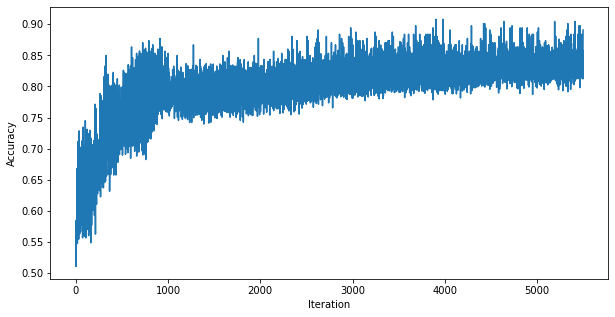

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

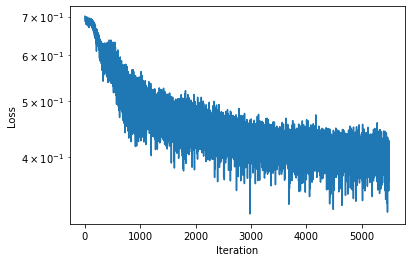

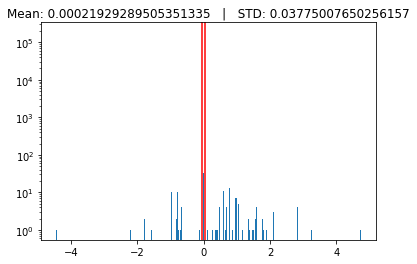

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 5.944444444444445


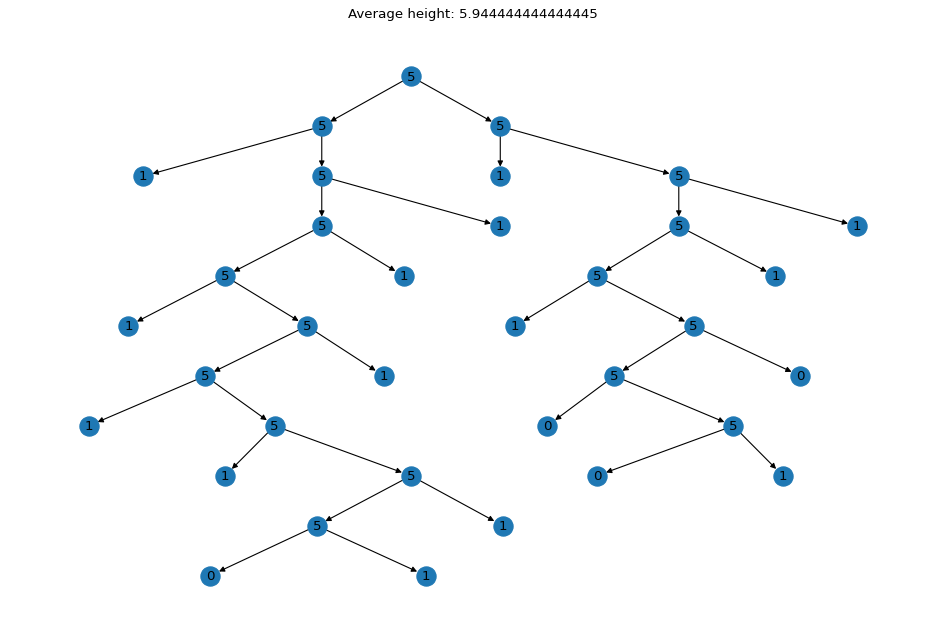

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 18


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
Average comprehensibility: 54.666666666666664


/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


In [23]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

Accuracy: 0.8189523220062256


In [24]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

Sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1.0: 0.9723756906077348
layer 2.0: 0.9723756906077348
layer 3.0: 0.9723756906077348
layer 4.0: 0.9723756906077348
layer 5.0: 0.9723756906077348
layer 6.0: 0.9723756906077349
layer 7.0: 0.9723756906077345
layer 8.0: 0.9723756906077345


## Prune the weights

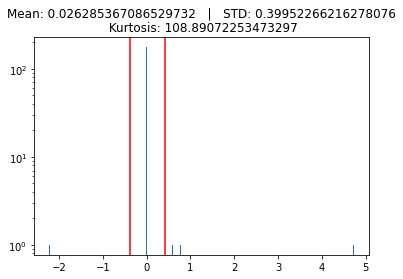

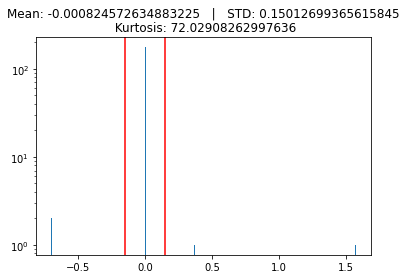

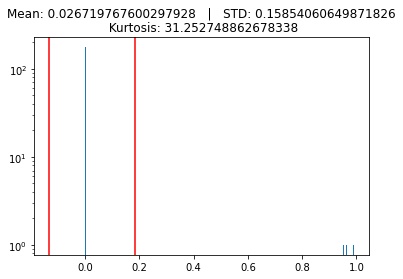

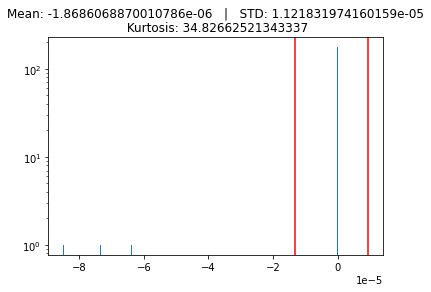

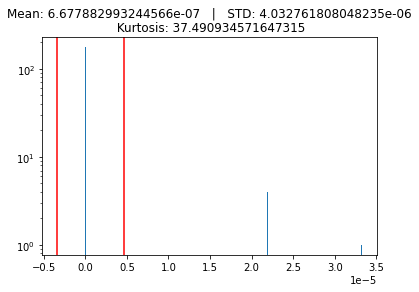

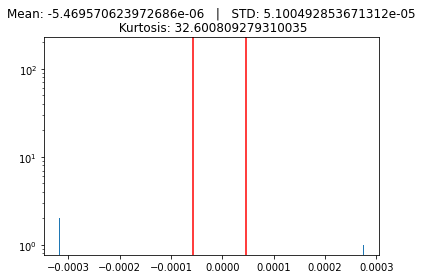

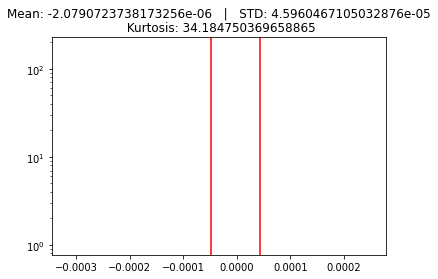

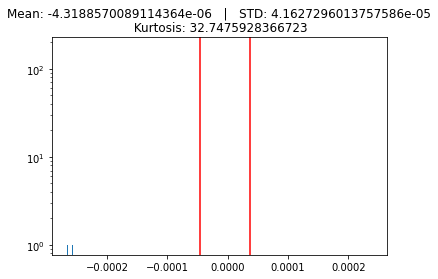

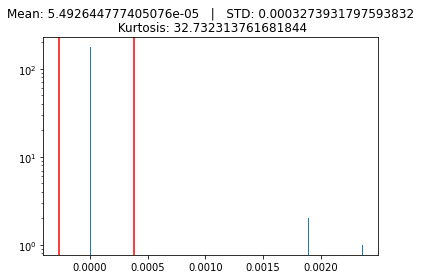

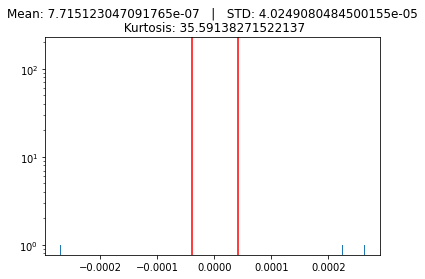

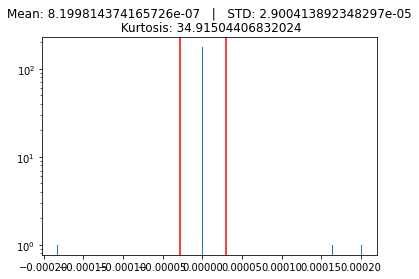

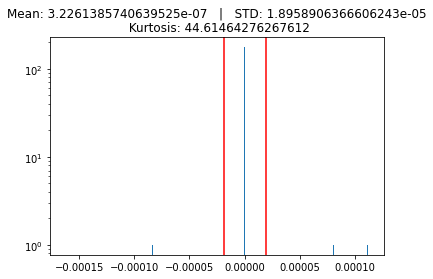

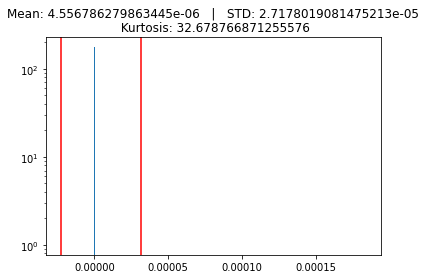

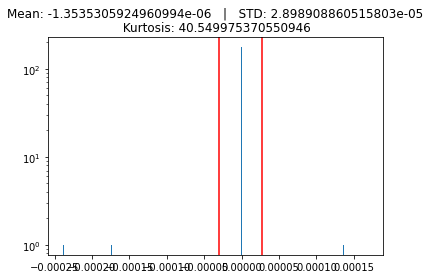

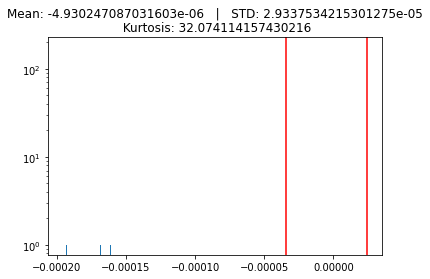

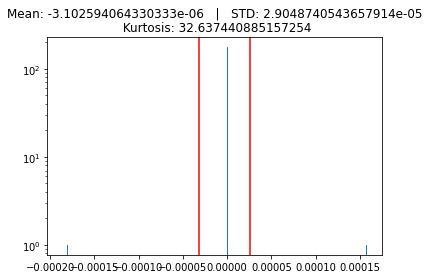

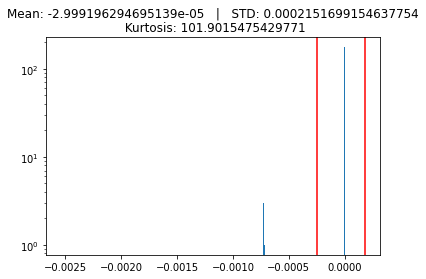

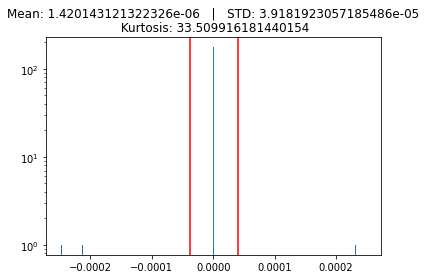

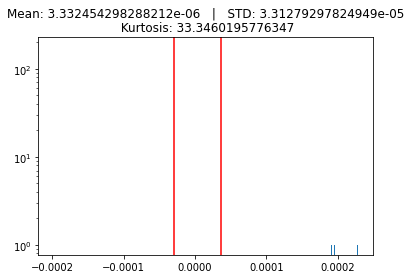

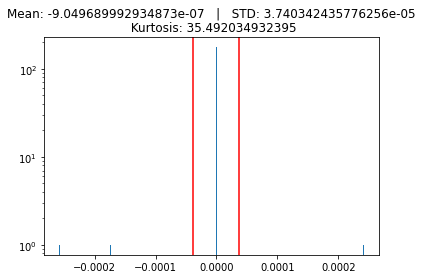

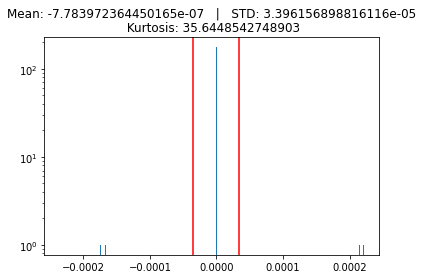

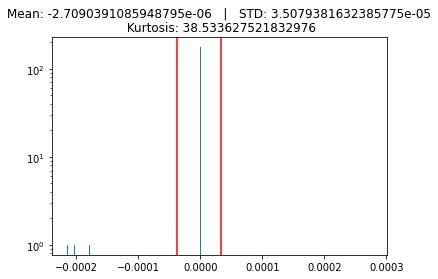

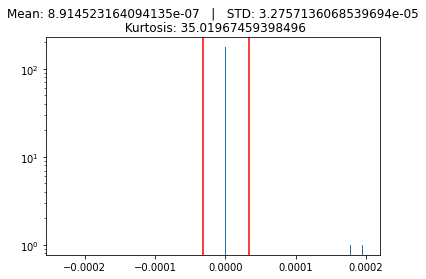

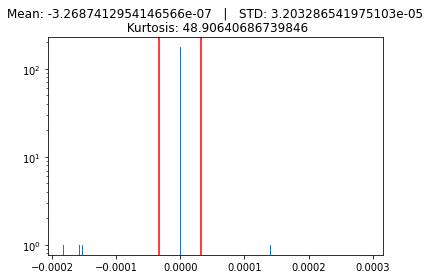

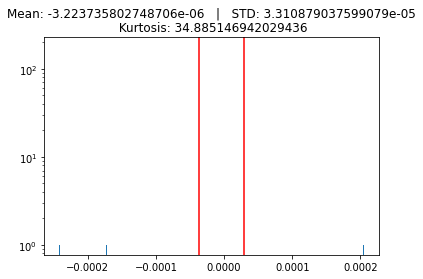

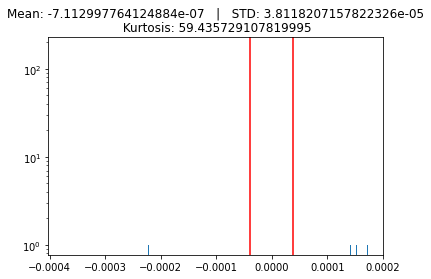

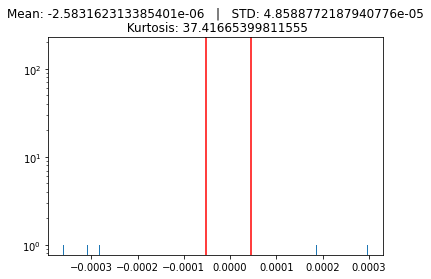

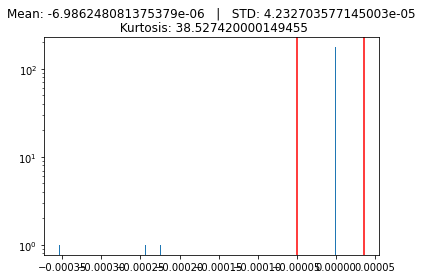

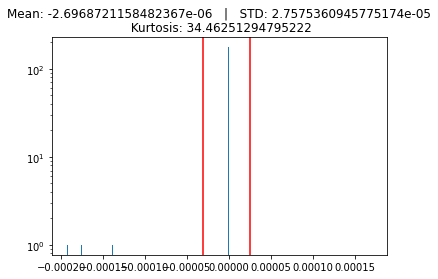

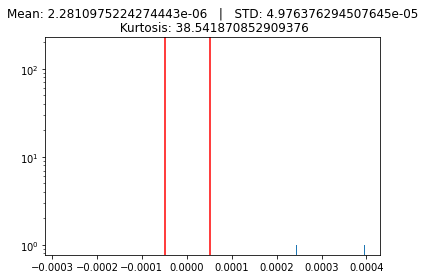

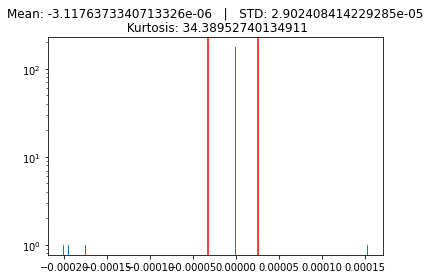

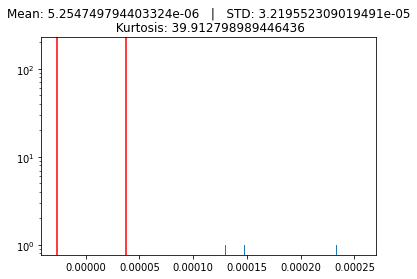

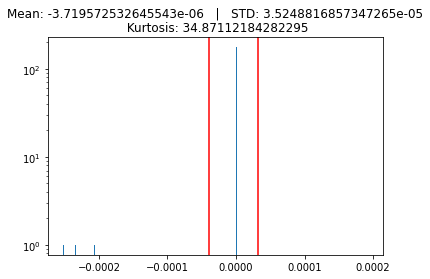

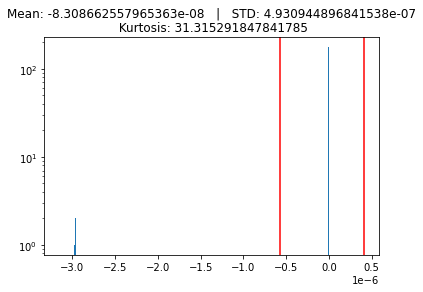

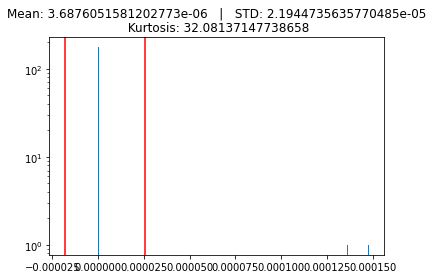

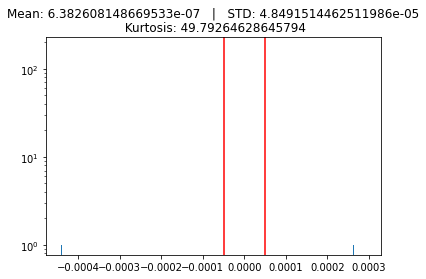

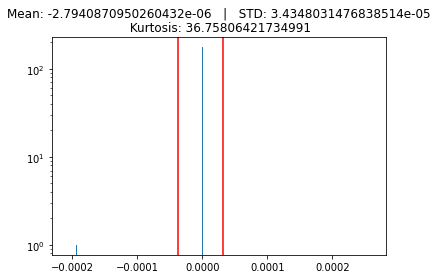

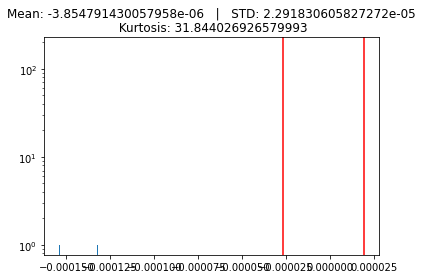

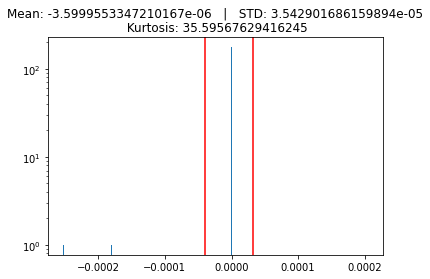

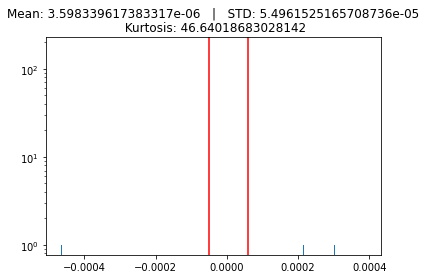

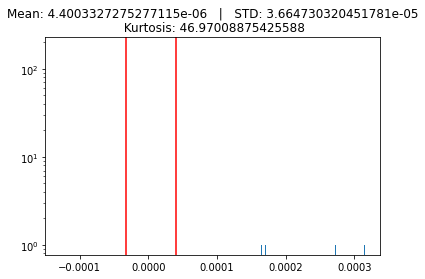

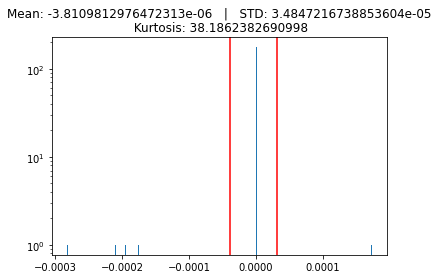

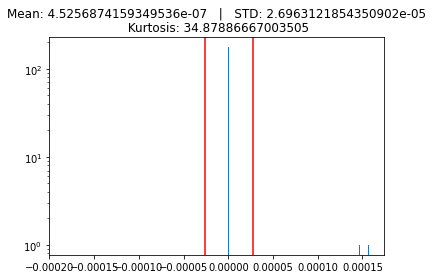

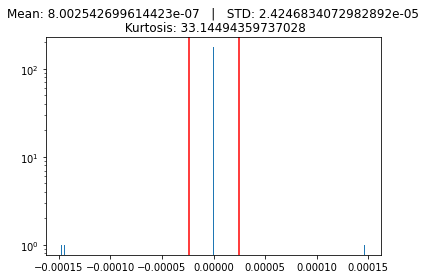

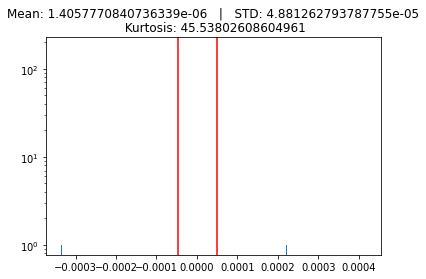

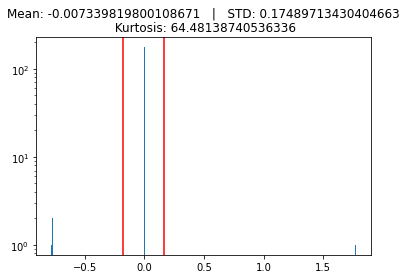

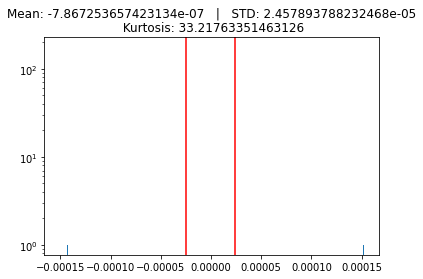

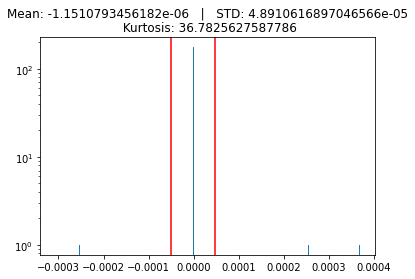

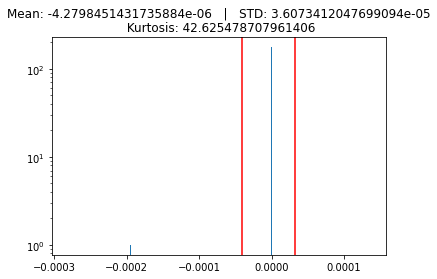

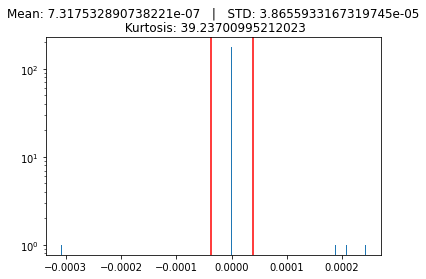

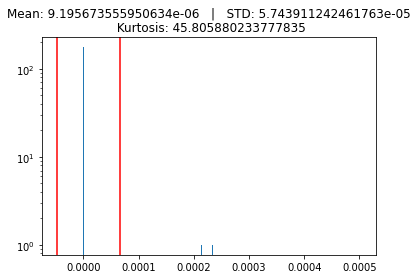

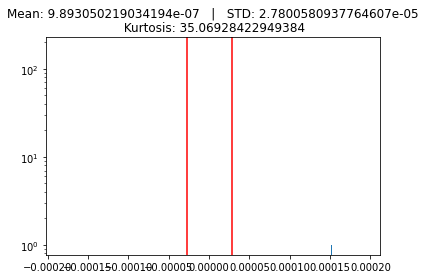

In [25]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [26]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


NameError: name 'tree_copy' is not defined

In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()